# Applied Airline Example

In [121]:
import pandas as pd
import arviz as az
pd.options.display.max_rows = 999

import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from scipy import stats, optimize

np.random.seed(seed=233423)
random_seed = 0

In [122]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300 

## Load flight data

In [123]:
df = pd.read_csv("../data/948363589_T_ONTIME_MARKETING.zip", low_memory=False)

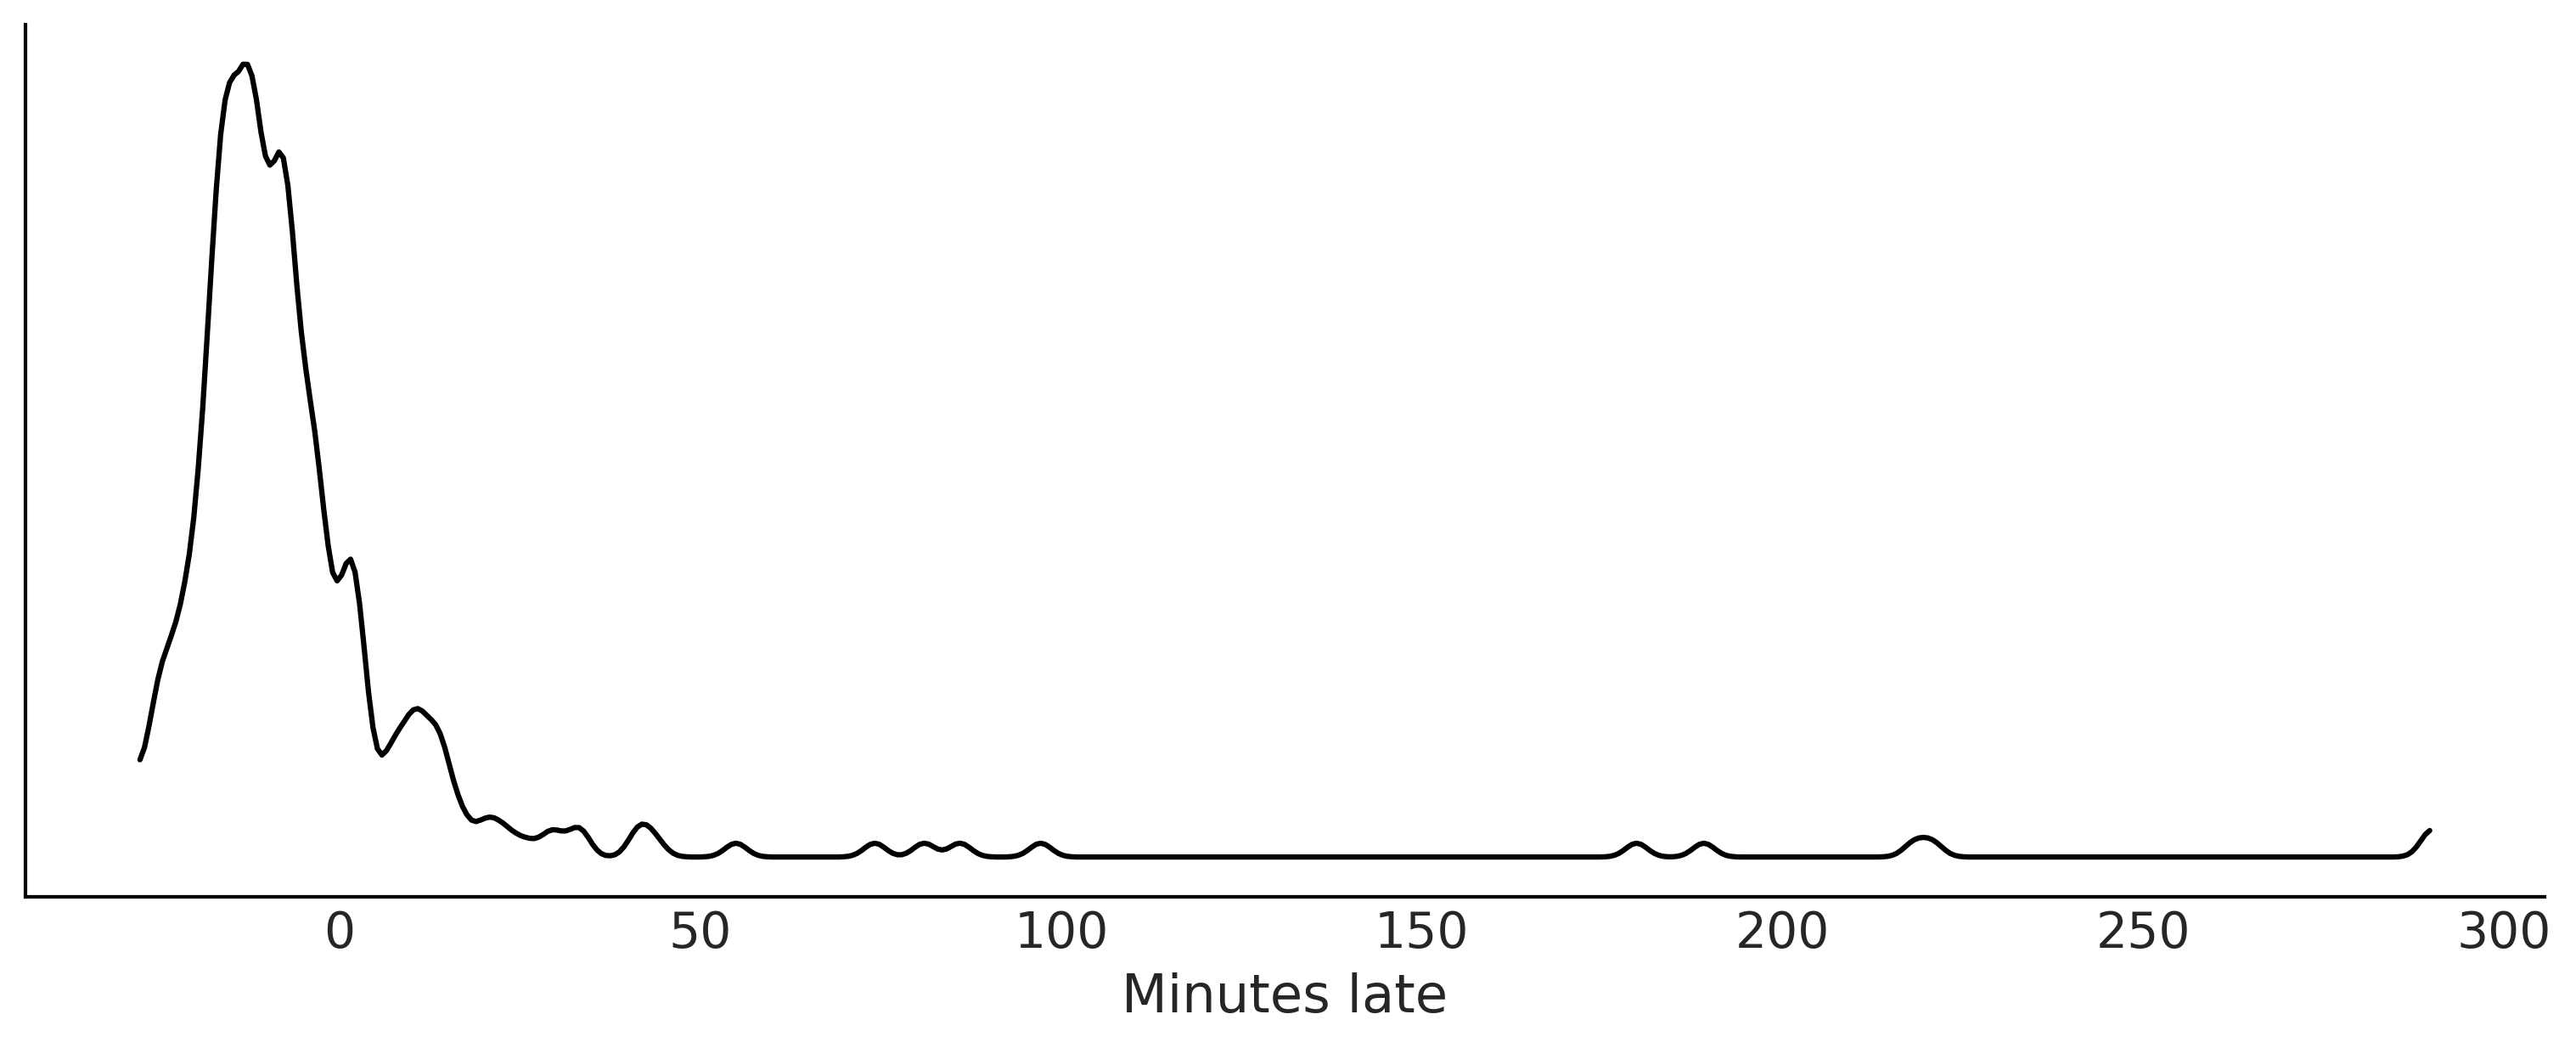

In [124]:
fig, ax = plt.subplots(figsize=(10,4))
msn_arrivals = df[(df["DEST"] == 'MSN') & df["ORIGIN"]
                  .isin(["MSP", "DTW"])]["ARR_DELAY"]

az.plot_kde(msn_arrivals.values, ax=ax)
ax.set_yticks([])
ax.set_xlabel("Minutes late")
plt.savefig('img/ArrivalDistributions.png')

In [125]:
msn_arrivals.notnull().value_counts()

True    336
Name: ARR_DELAY, dtype: int64

In [126]:
try:
    # This is the real code, just try except block to allow for the whole notebook tor execute
    with pm.Model() as normal_model:
        normal_mu = ...
        normal_sd = ...

        normal_delay = pm.SkewNormal("delays", mu=normal_mu,
                                     sd=normal_sd, observed=msn_arrivals)

    with pm.Model() as skew_normal_model:
        skew_normal_alpha = ...
        skew_normal_mu = ...
        skew_normal_sd = ...

        skew_normal_delays = pm.SkewNormal("delays", mu=skew_normal_mu, sd=skew_normal_sd,
                                           alpha=skew_normal_alpha, observed=msn_arrivals)


    with pm.Model() as gumbel_model:
        gumbel_beta = ...
        gumbel_mu = ...

        gumbel_delays = pm.Gumbel("delays", mu=gumbel_mu,
                                  beta=gumbel_beta, observed=msn_arrivals)
except:
    pass

### Airline Example: Picking Priors

In [127]:
samples = 1000

with pm.Model() as normal_model:
    normal_sd = pm.HalfStudentT("sd",sigma=60, nu=5)
    normal_mu = pm.Normal("mu", 0, 30) 

    normal_delay = pm.Normal("delays", mu=normal_mu, sd=normal_sd, observed=msn_arrivals)
    normal_prior_predictive = pm.sample_prior_predictive()
    
with pm.Model() as gumbel_model:
    gumbel_beta = pm.HalfStudentT("beta", sigma=60, nu=5)
    gumbel_mu = pm.Normal("mu", 0, 20)
    
    gumbel_delays = pm.Gumbel("delays", mu=gumbel_mu, beta=gumbel_beta, observed=msn_arrivals)
    gumbel_predictive = pm.sample_prior_predictive()


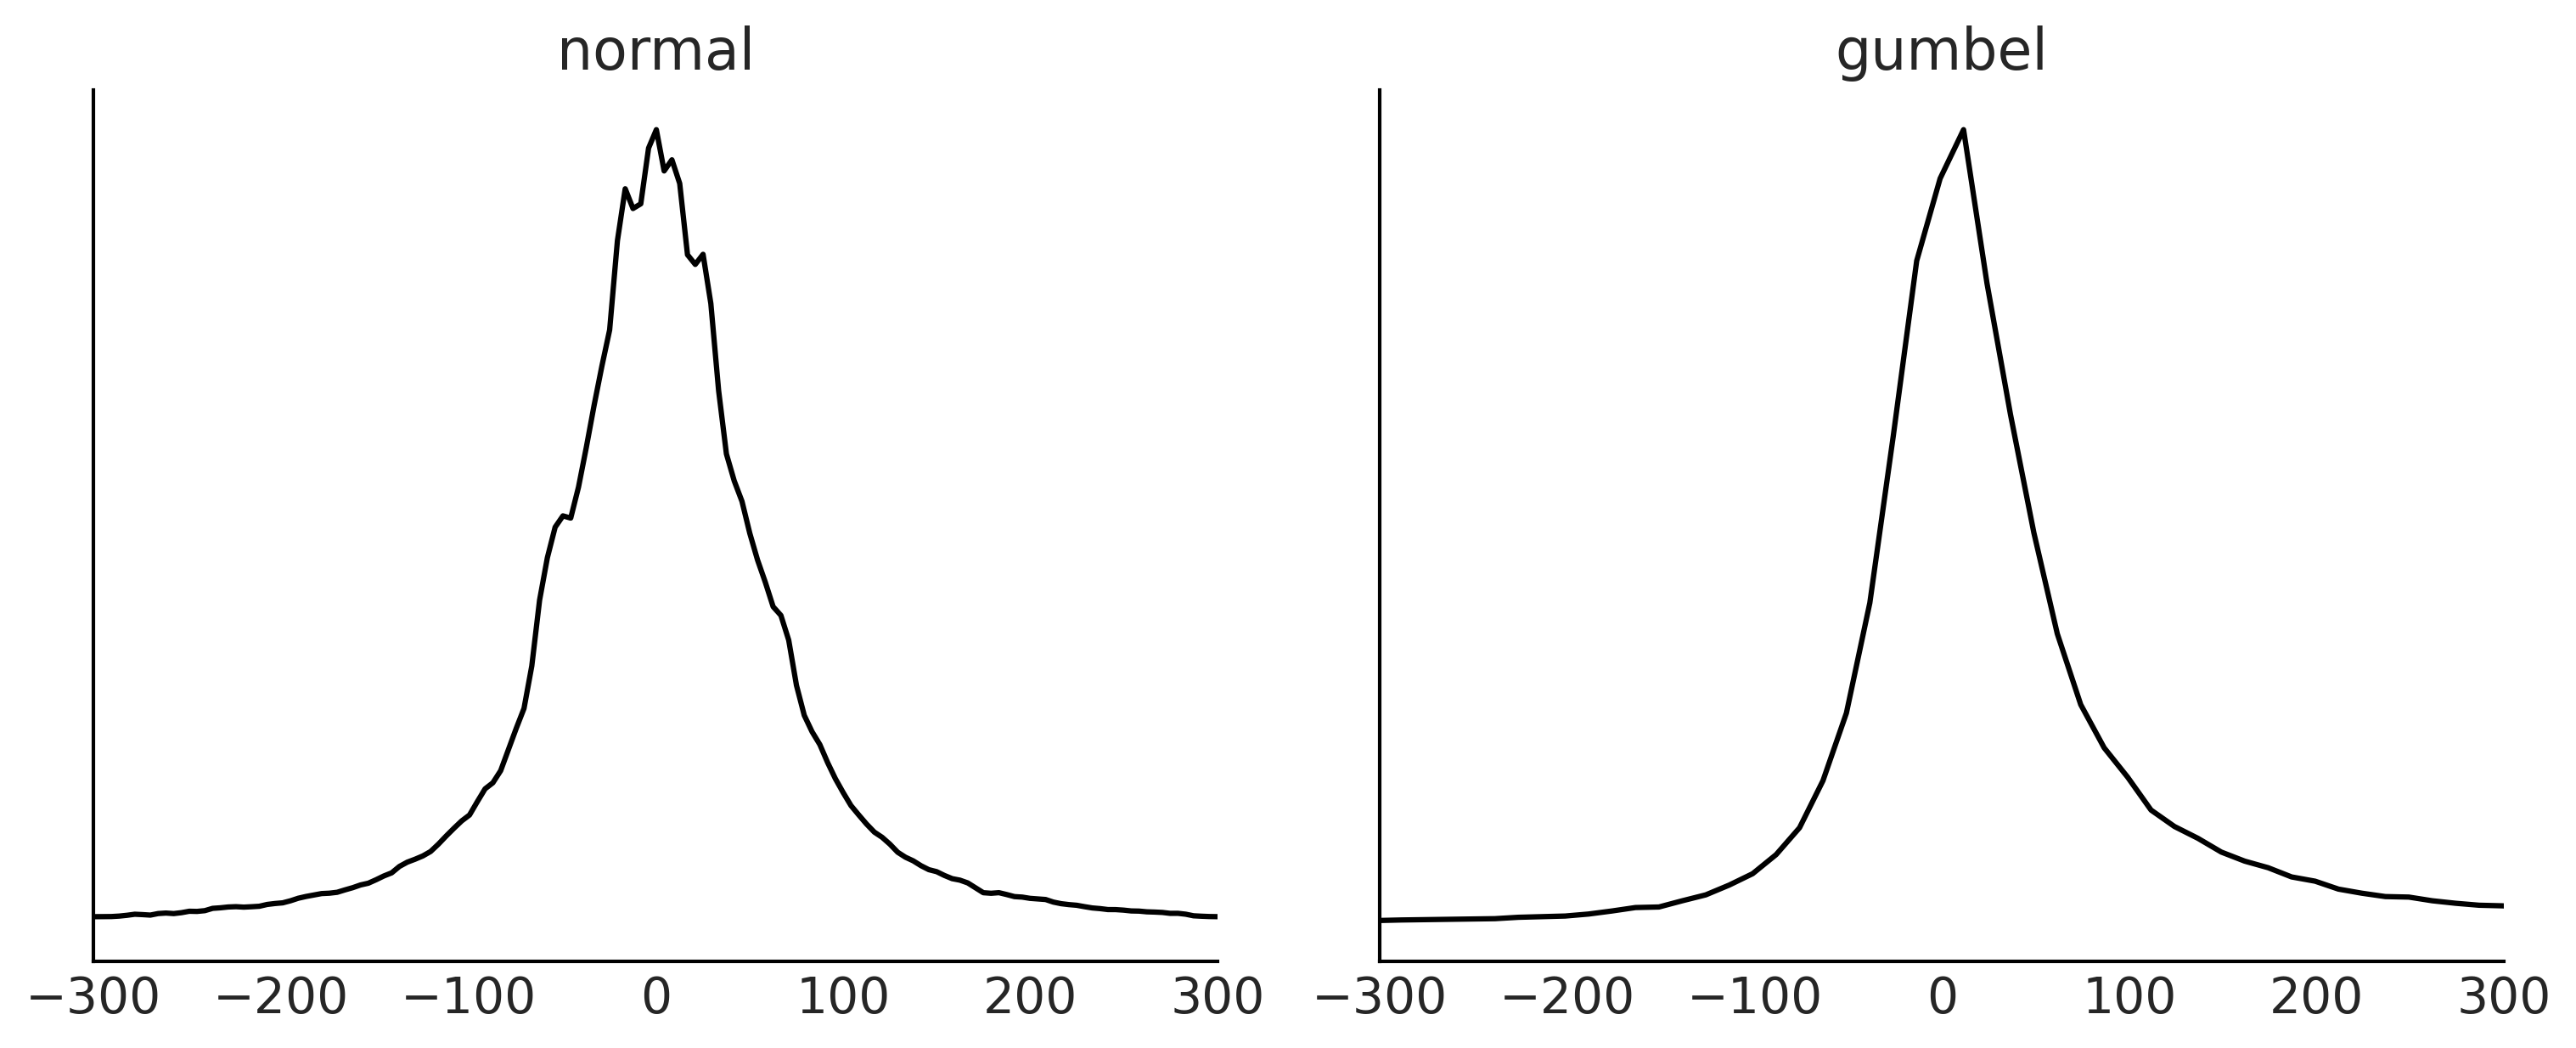

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

prior_predictives = {"normal":normal_prior_predictive, "gumbel": gumbel_predictive }

for i, (label, prior_predictive) in enumerate(prior_predictives.items()):
    # Need to fix arviz issue where prior predictive is not working
    #idata = az.from_pymc3(prior=normal_prior_predictive)
    #az.plot_ppc(idata, group="prior", ax=axes[i])
    
    data = prior_predictive["delays"].flatten()
    #pd.Series(data).plot(kind="kde", ax=axes[i])
    az.plot_dist(data, ax=axes[i])
    axes[i].set_yticks([])
    axes[i].set_xlim(-300, 300)
    axes[i].set_title(label)
fig.savefig("img/Airline_Prior_Predictive.png")

## Inference Diagnostics


/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sd]


/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


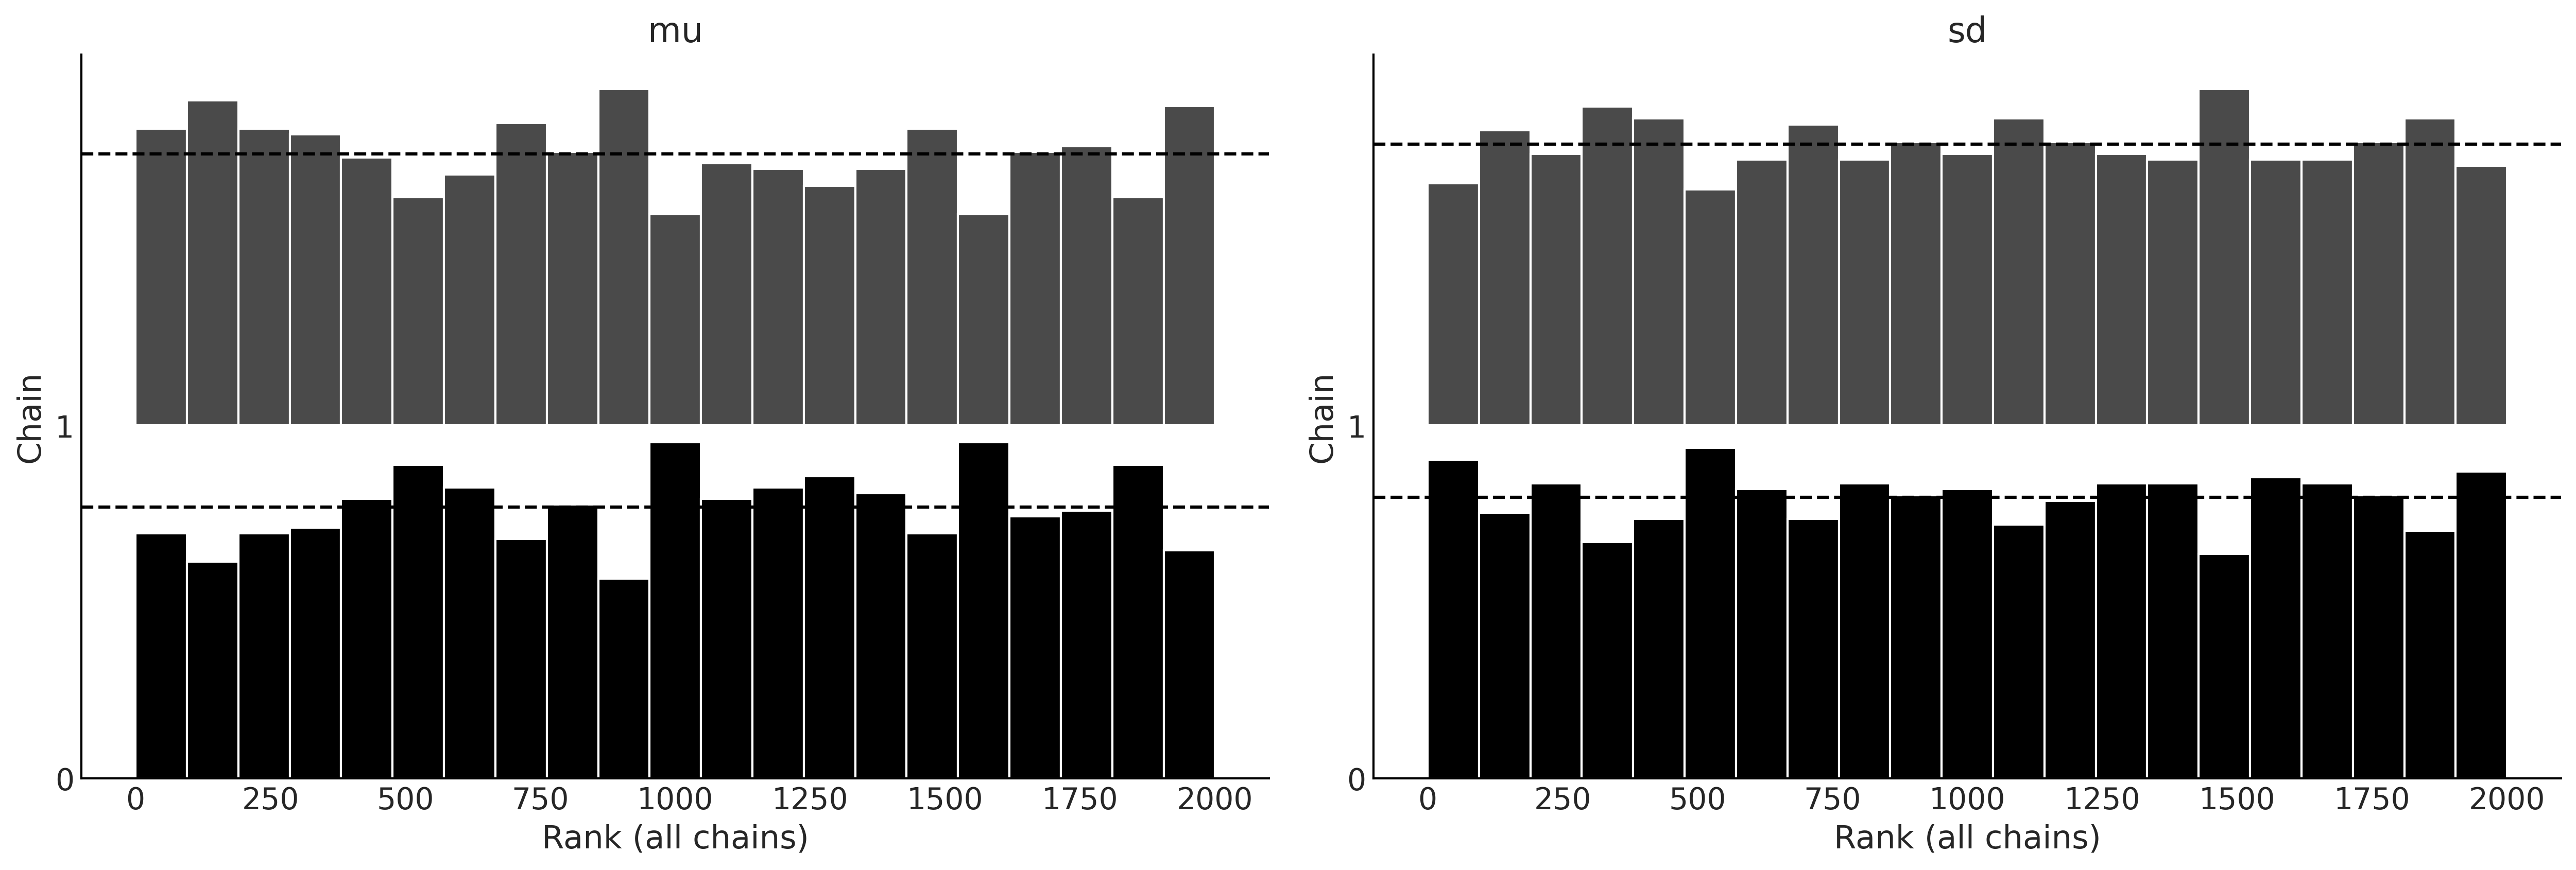

In [129]:
with normal_model:
    normal_delay_trace = pm.sample(random_seed=0, chains=2)
    az.plot_rank(normal_delay_trace)
plt.savefig('img/rank_plot_bars_normal.png')

/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, beta]


/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 5 seconds.


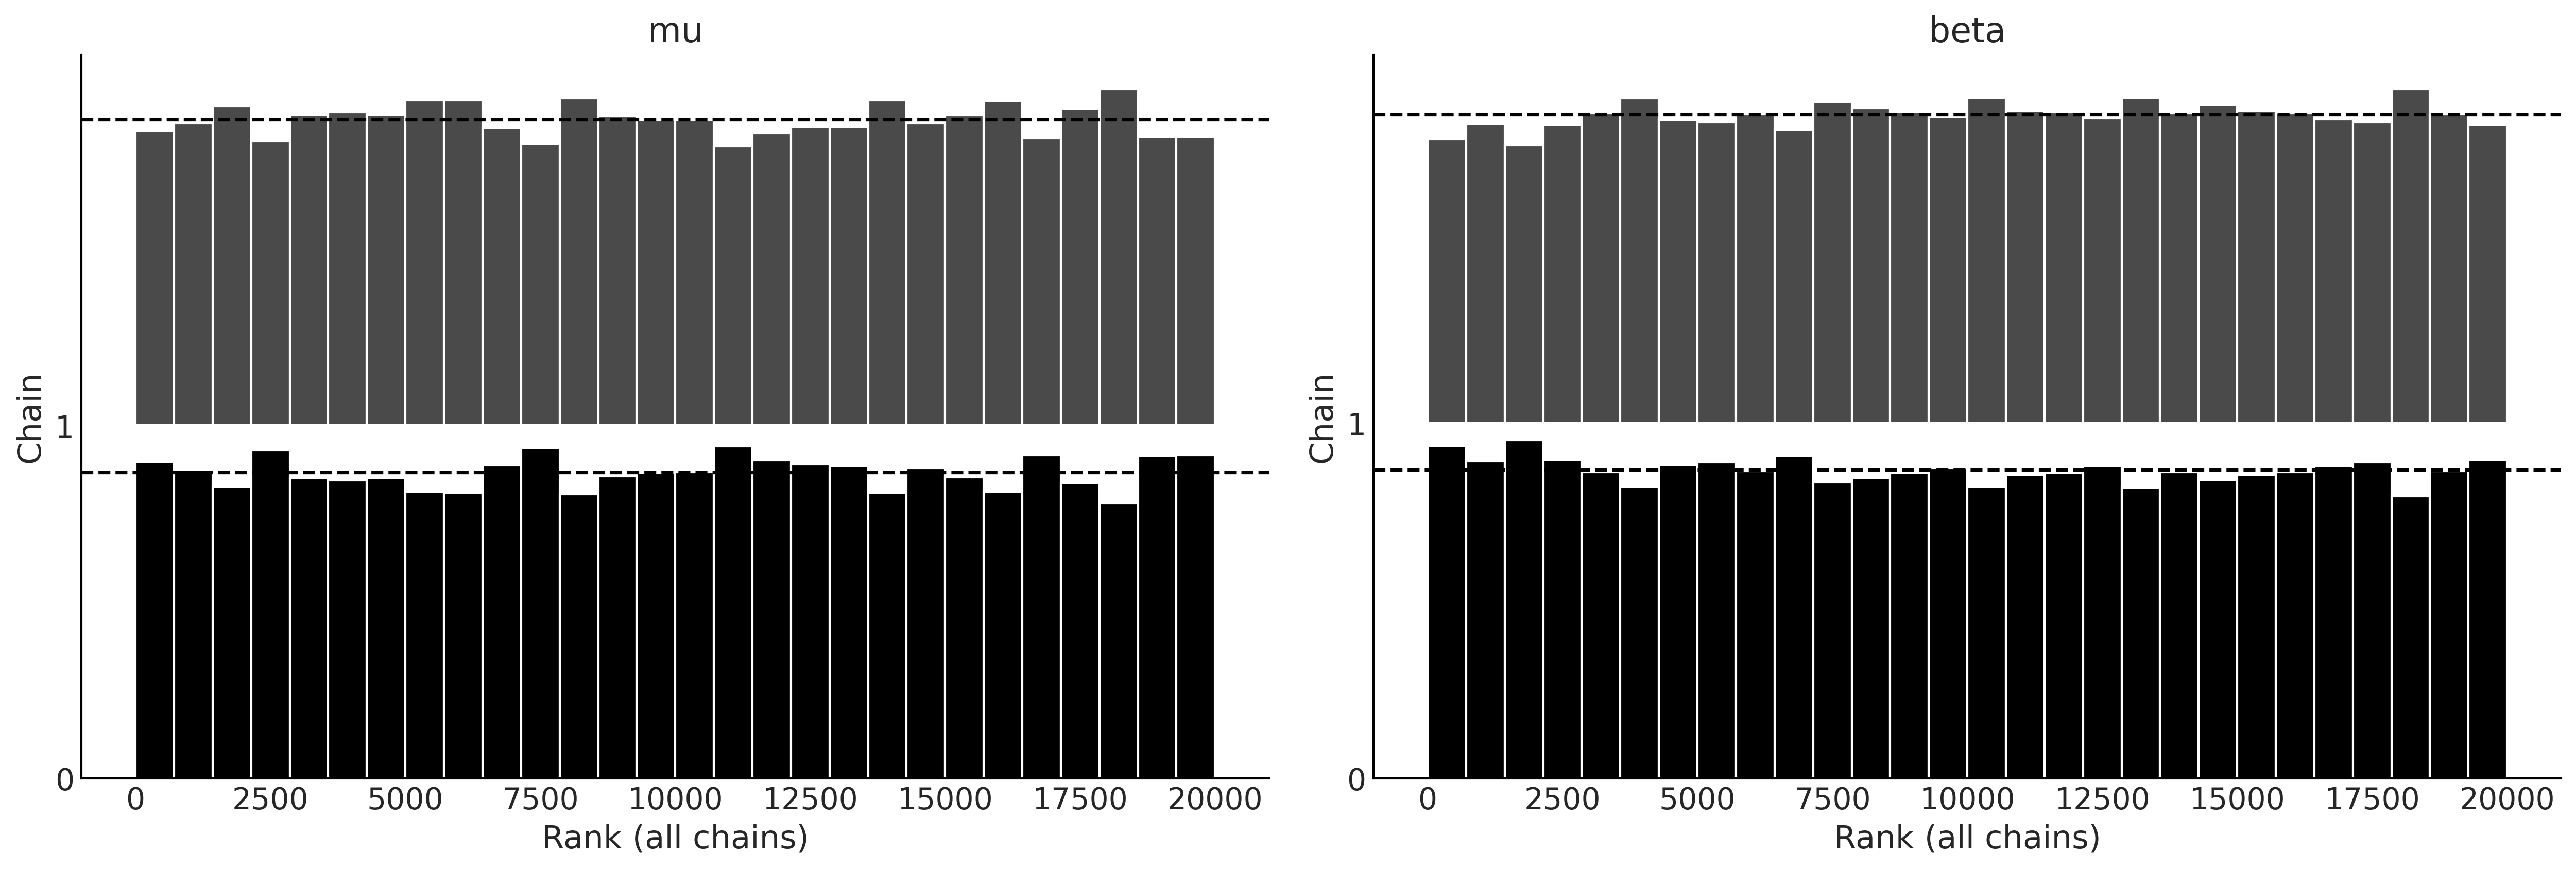

In [130]:
with gumbel_model:
    gumbel_delay_trace = pm.sample(random_seed=0, chains=2, draws=10000)
    az.plot_rank(gumbel_delay_trace)
plt.savefig('img/rank_plot_bars_gumbel.png')

## Posterior Plots

/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


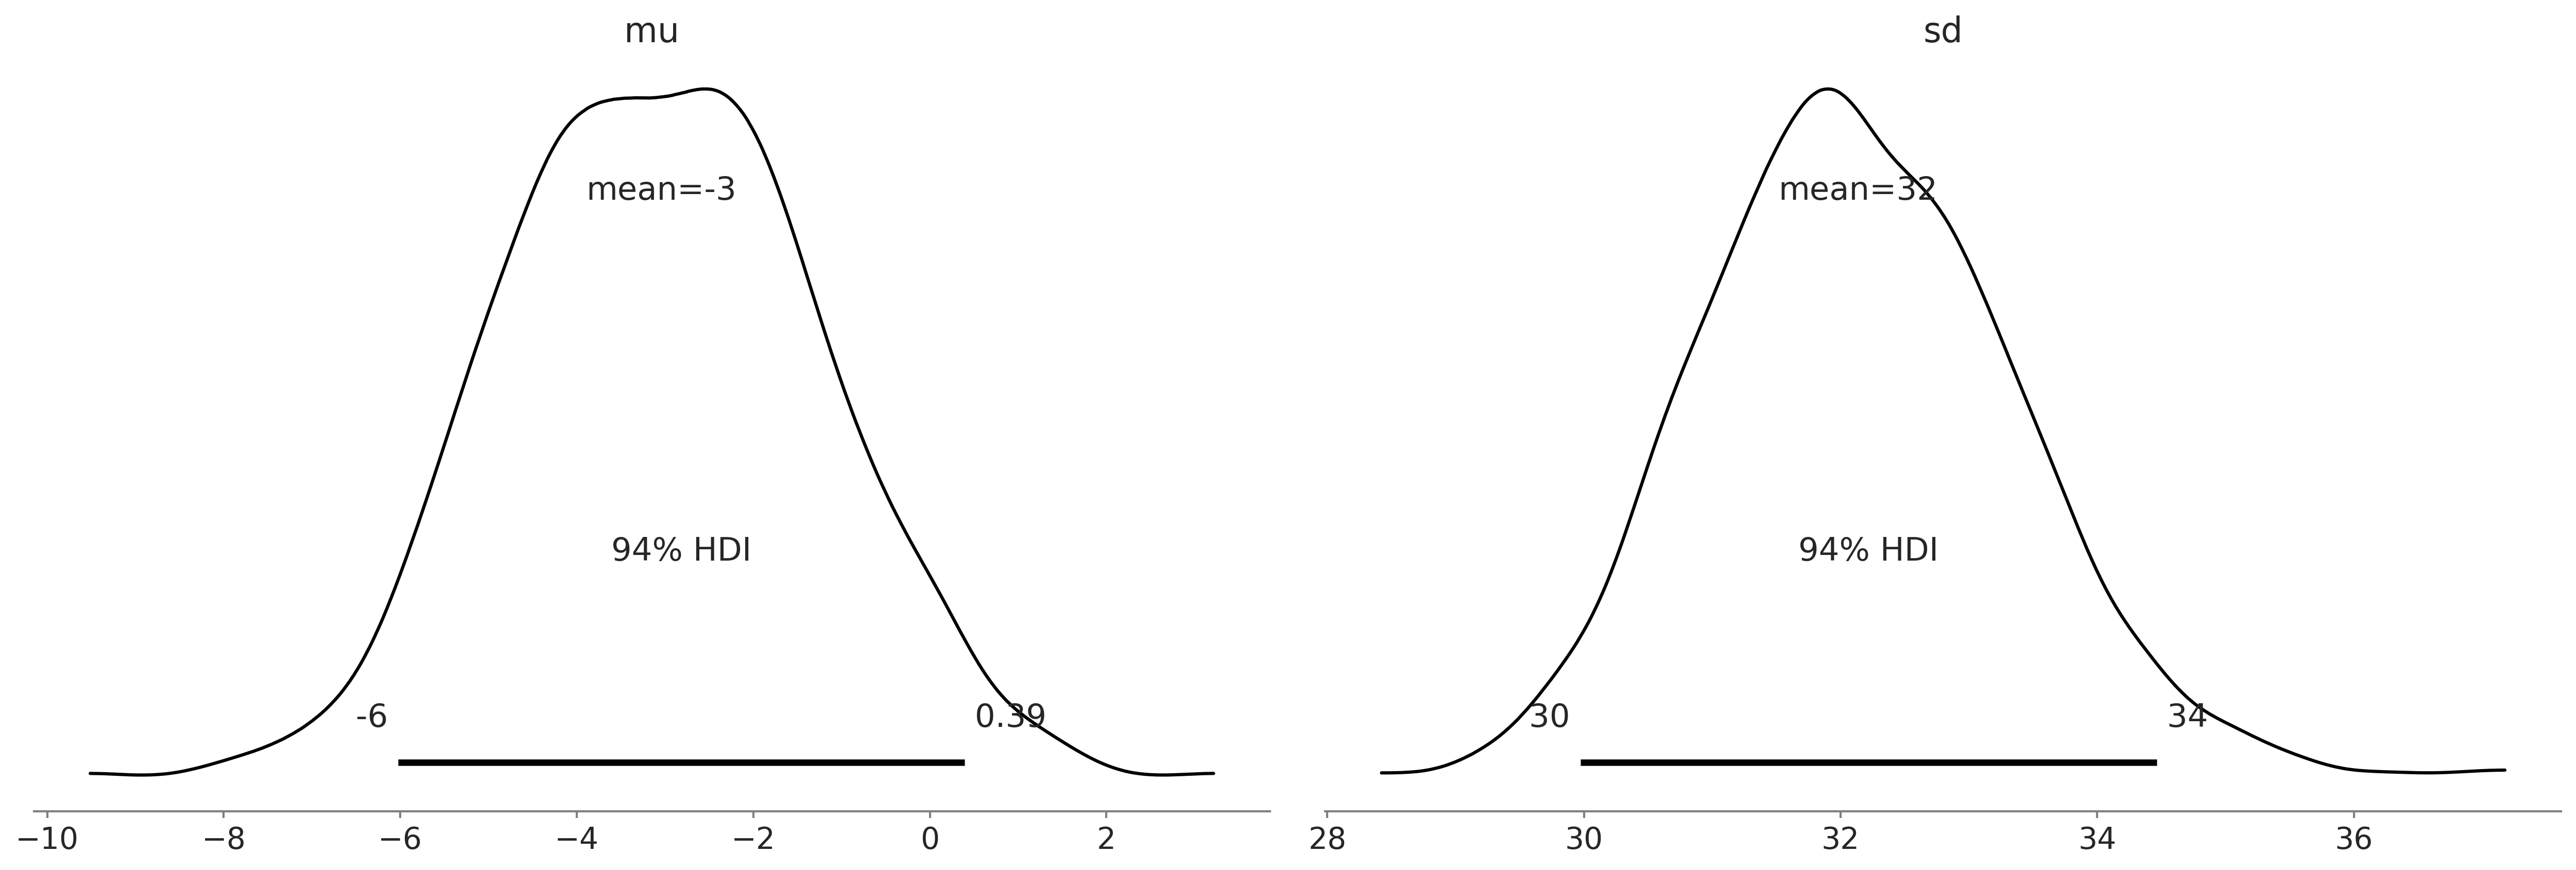

In [131]:
az.plot_posterior(normal_delay_trace)
plt.savefig('img/posterior_plot_delays_normal.png');

/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


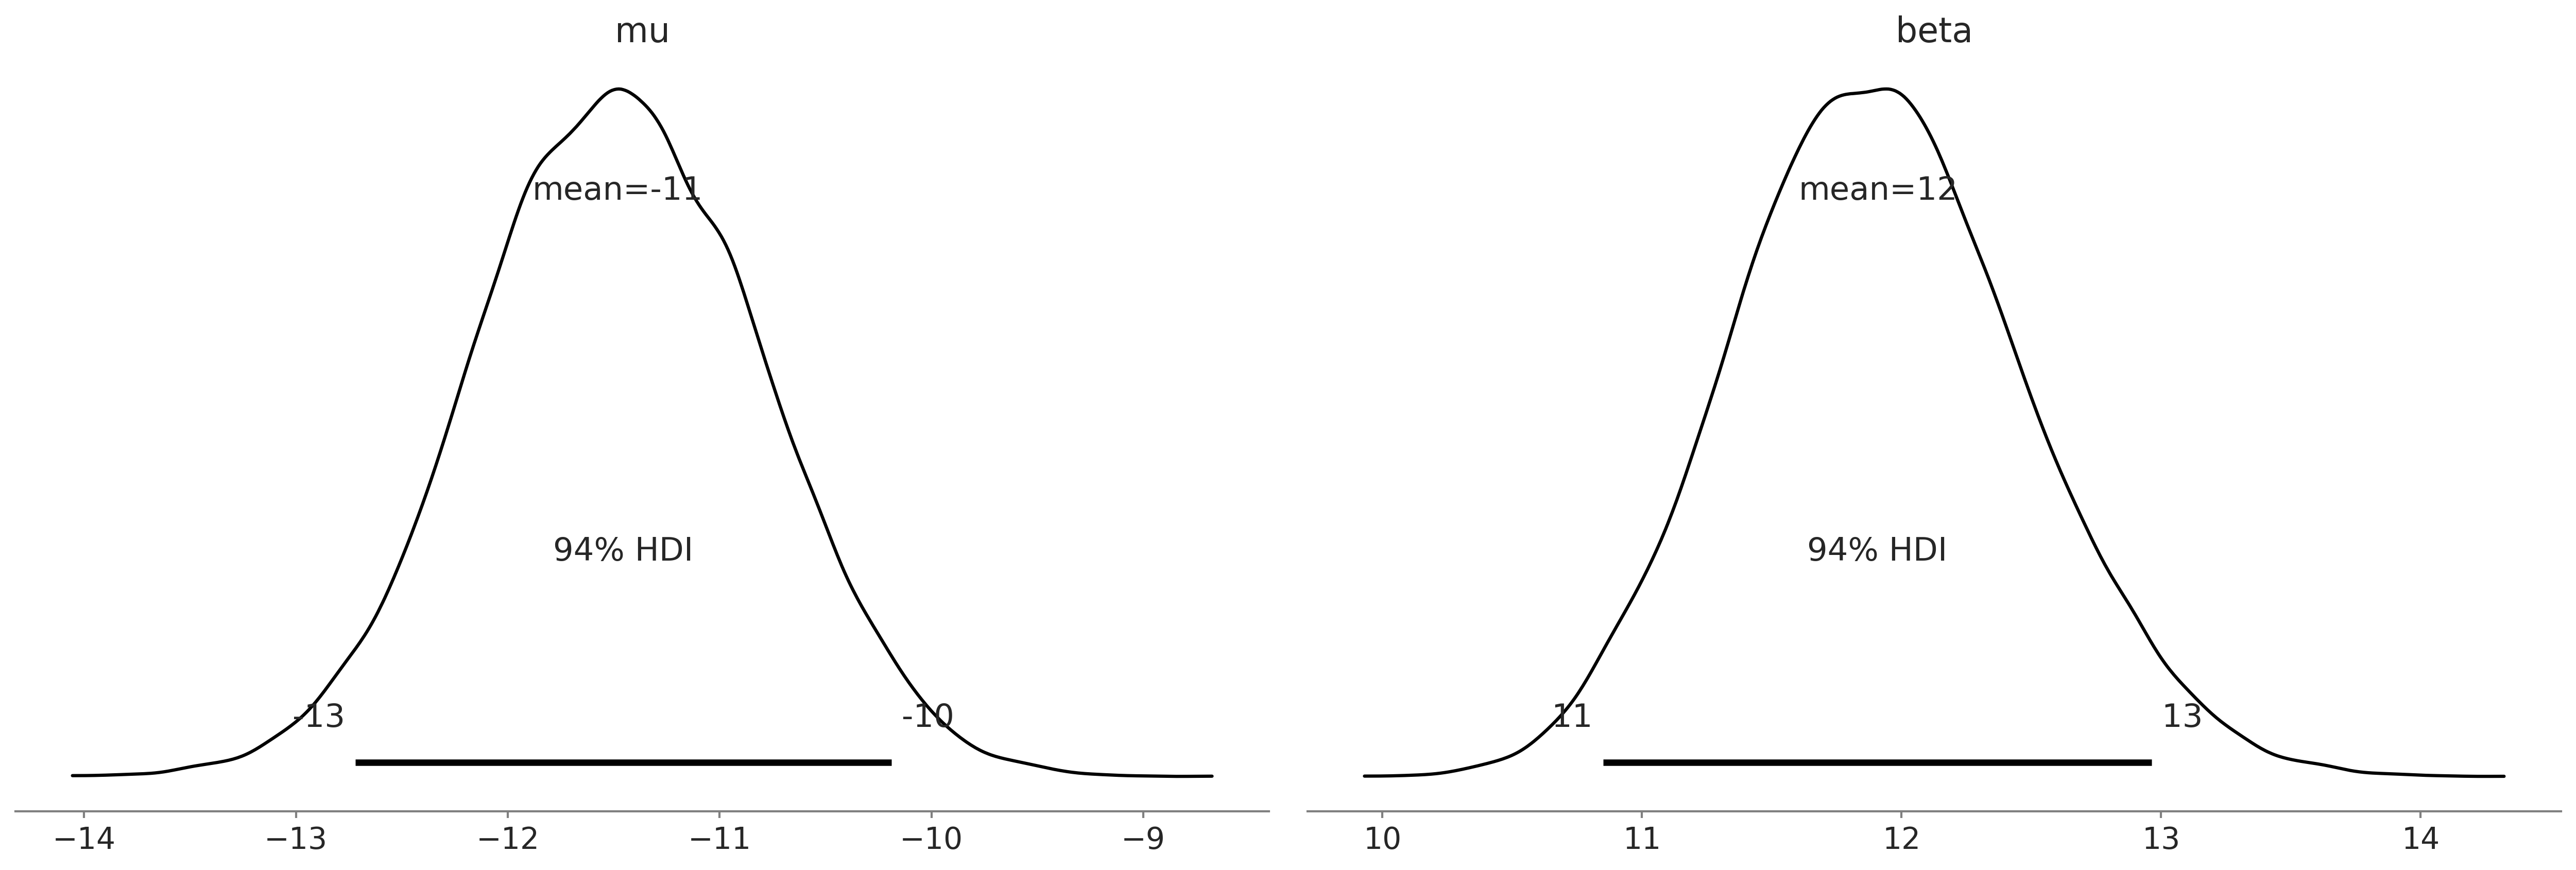

In [132]:
az.plot_posterior(gumbel_delay_trace)
plt.savefig('img/posterior_plot_delays_gumbel.png');

## Posterior Predictive Plots

## Normal Posterior Predictive

In [133]:
with normal_model:
    normal_delay_trace = pm.sample(random_seed=0)
    normal_post_pred_check = pm.sample_posterior_predictive(normal_delay_trace, random_seed=0)
    normal_data = az.from_pymc3(trace=normal_delay_trace, posterior_predictive=normal_post_pred_check)

/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sd]


/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<AxesSubplot:xlabel='delays'>], dtype=object)

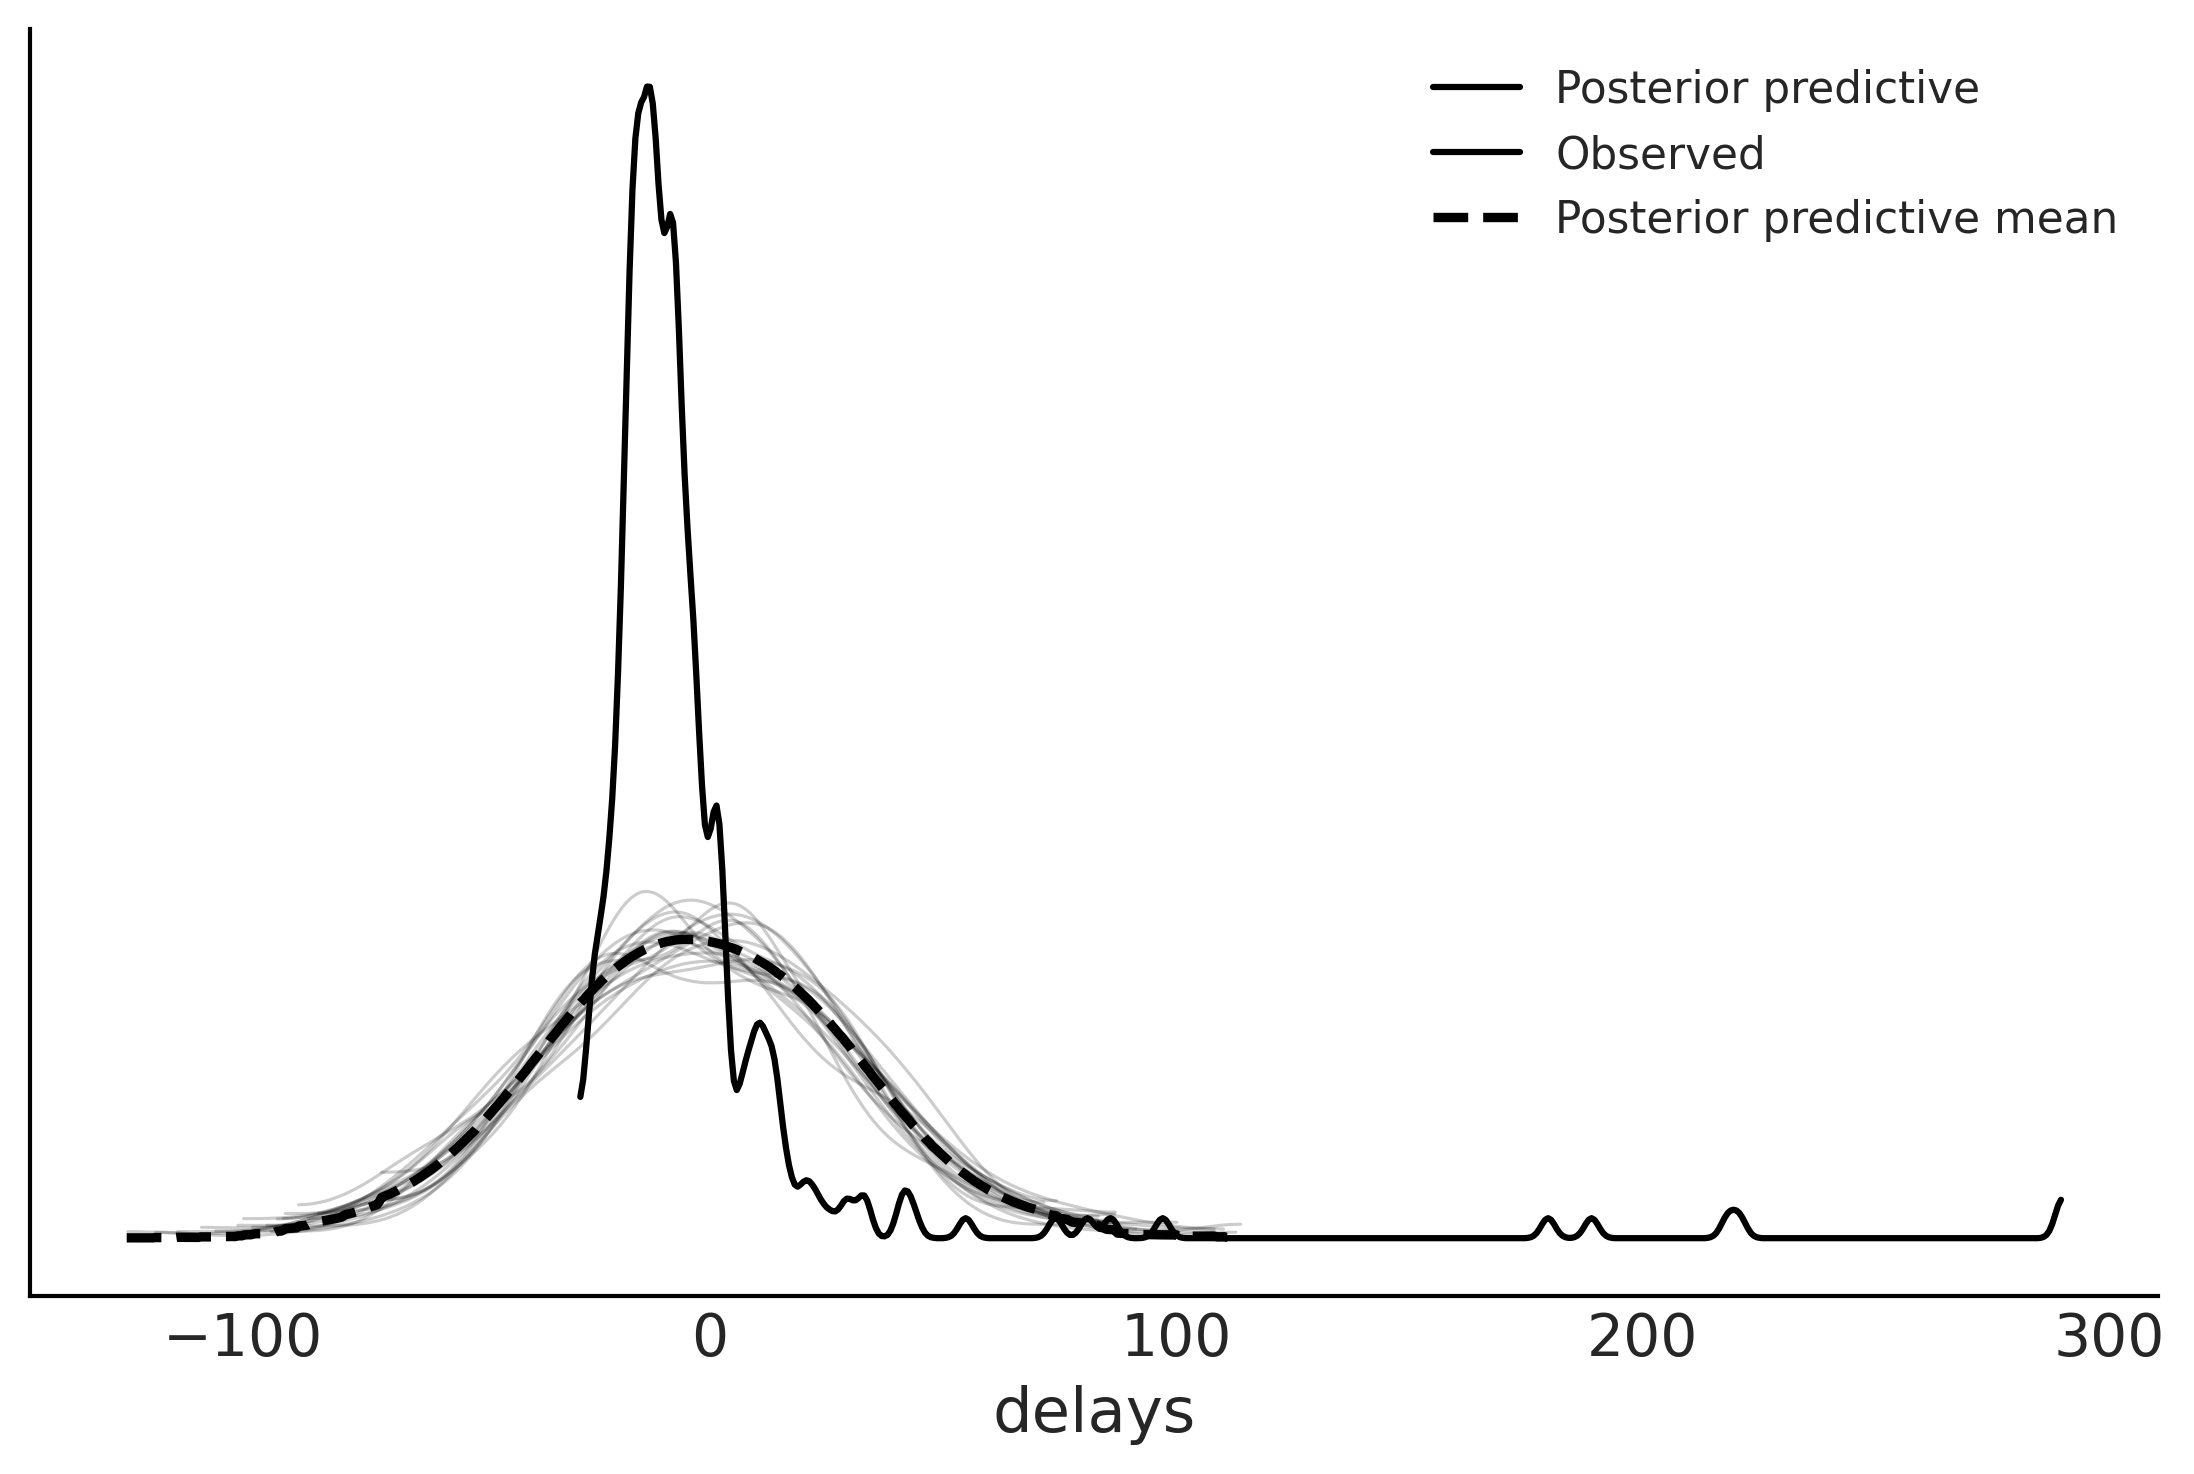

In [134]:
fig, ax = plt.subplots()
az.plot_ppc(normal_data, observed=True, num_pp_samples=20, ax=ax)

## Gumbel Posterior Predictive

In [135]:
with gumbel_model:
    gumbel_post_pred_check = pm.sample_posterior_predictive(gumbel_delay_trace, random_seed=0)
    gumbel_data = az.from_pymc3(trace=gumbel_delay_trace, posterior_predictive=gumbel_post_pred_check)

In [136]:
gumbel_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

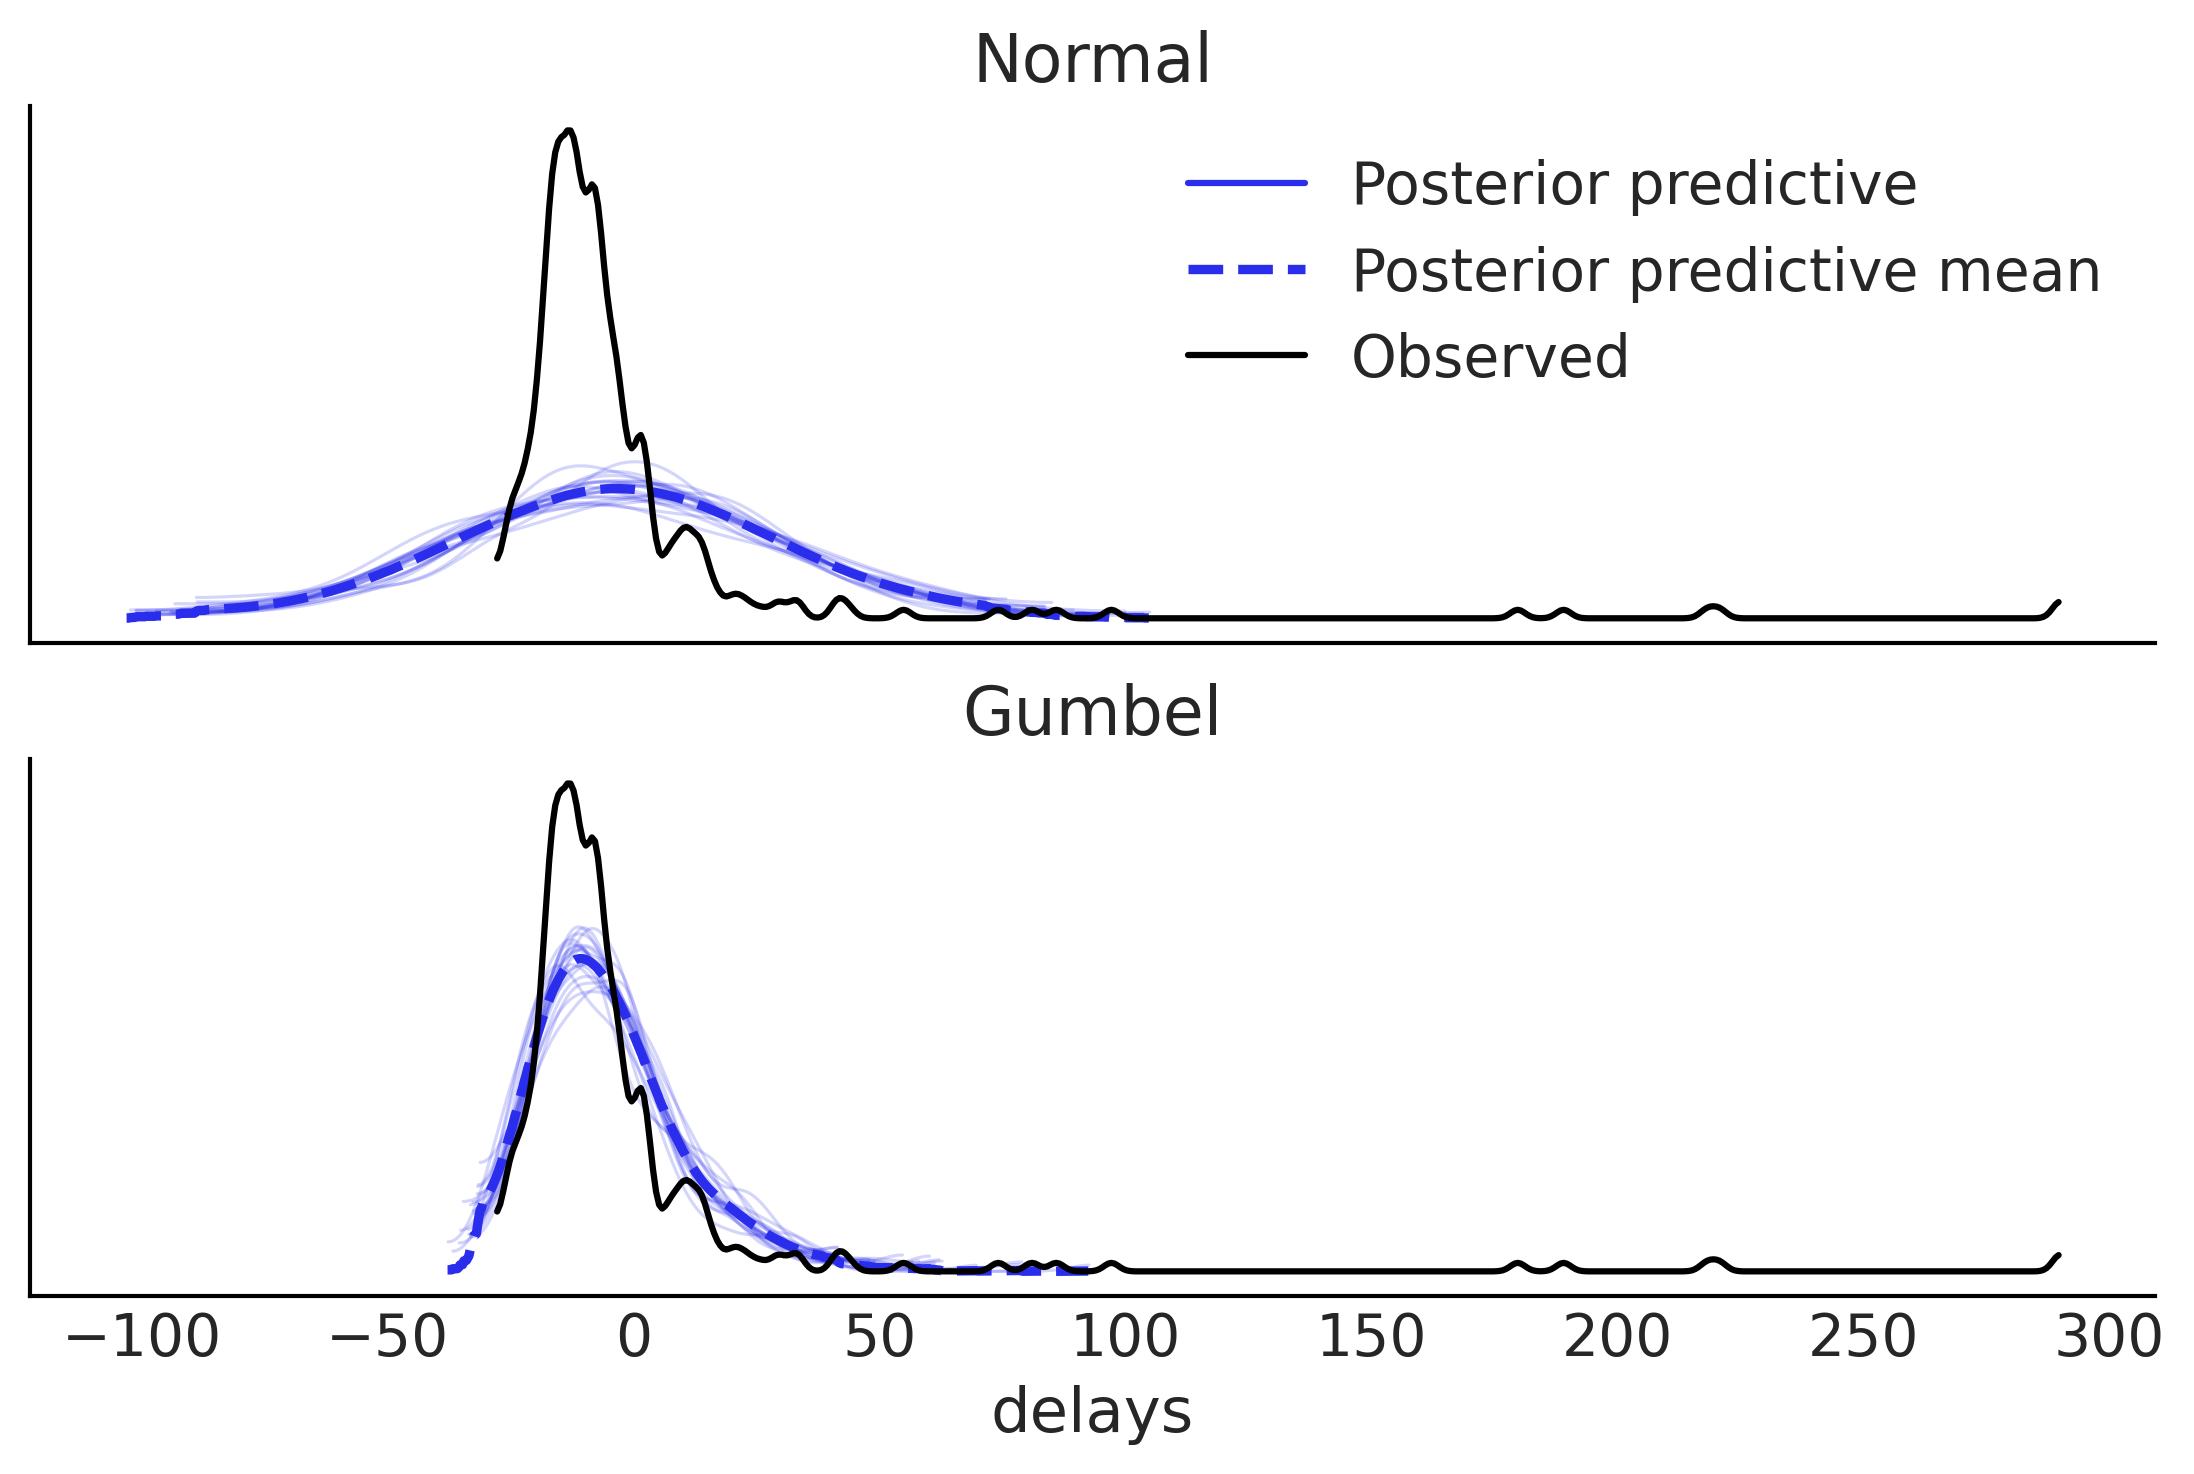

In [137]:
fig, ax = plt.subplots(2,1, sharex=True)

az.plot_ppc(normal_data, observed=False, num_pp_samples=20, ax=ax[0], color="C4")
az.plot_kde(msn_arrivals, ax=ax[0], label="Observed");

az.plot_ppc(gumbel_data, observed=False, num_pp_samples=20, ax=ax[1], color="C4")
az.plot_kde(msn_arrivals, ax=ax[1], label="Observed");
ax[0].set_title("Normal")
ax[0].set_xlabel("")
ax[1].set_title("Gumbel")
ax[1].legend().remove()
plt.savefig("img/Delays_Model_Posterior_Predictive.png")

## Test Statistics

In [138]:
gumbel_late = gumbel_data.posterior_predictive["delays"].values.reshape(-1, 336).copy()
dist_of_late = (gumbel_late > 0).sum(axis=1) / 336


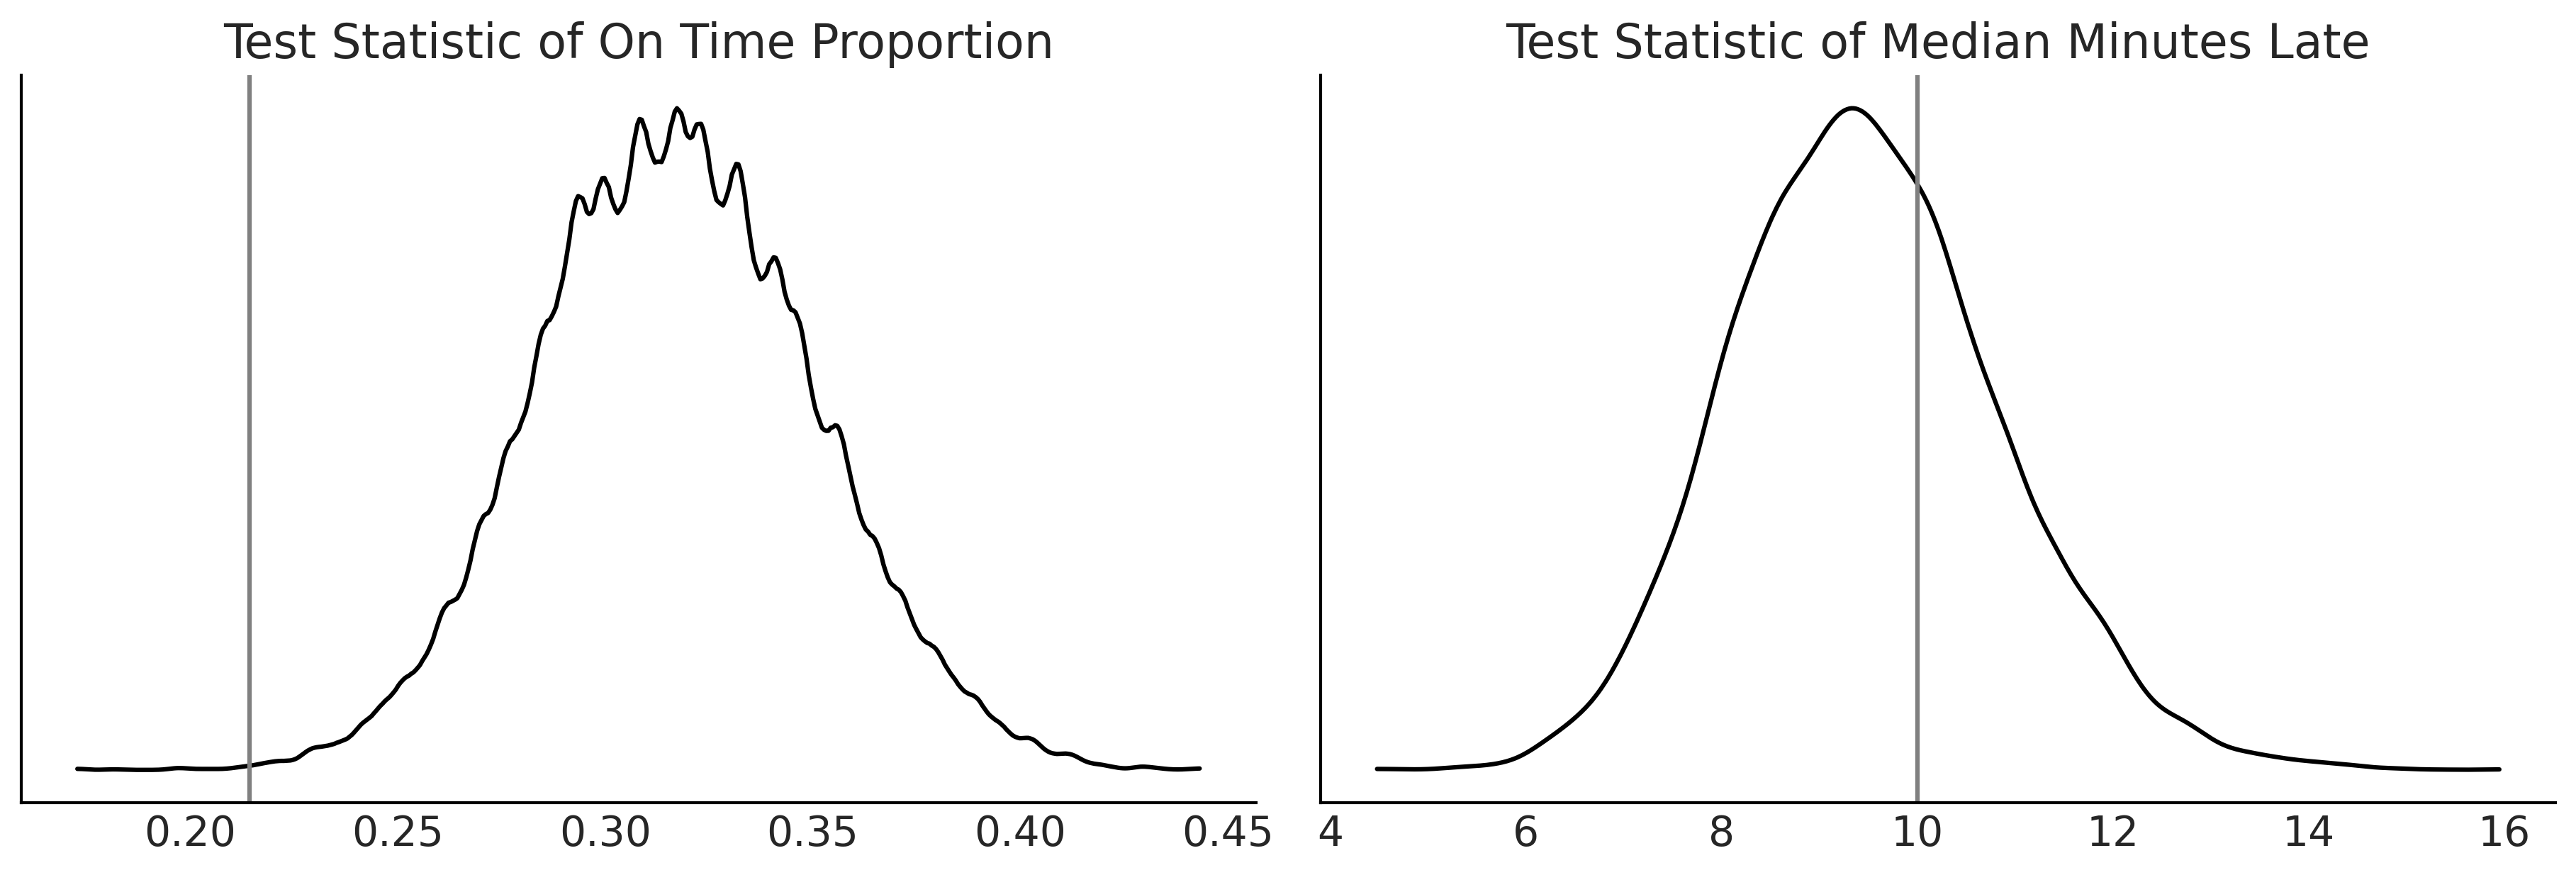

In [139]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

gumbel_late = gumbel_data.posterior_predictive["delays"].values.reshape(-1, 336).copy()
dist_of_late = (gumbel_late > 0).sum(axis=1) / 336
az.plot_dist(dist_of_late, ax=axes[0])

percent_observed_late = (msn_arrivals > 0).sum() / 336
axes[0].axvline(percent_observed_late, c="gray")
axes[0].set_title("Test Statistic of On Time Proportion")
axes[0].set_yticks([])


gumbel_late[gumbel_late < 0] = np.nan
median_lateness = np.nanmedian(gumbel_late, axis=1)
az.plot_dist(median_lateness,  ax=axes[1])

median_time_observed_late = msn_arrivals[msn_arrivals >= 0].median()
axes[1].axvline(median_time_observed_late, c="gray")
axes[1].set_title("Test Statistic of Median Minutes Late")
axes[1].set_yticks([])

plt.savefig("img/Arrival_Test_Statistics_for_Gumbel_Posterior_Predictive.png")

## LOO PIT Comparison

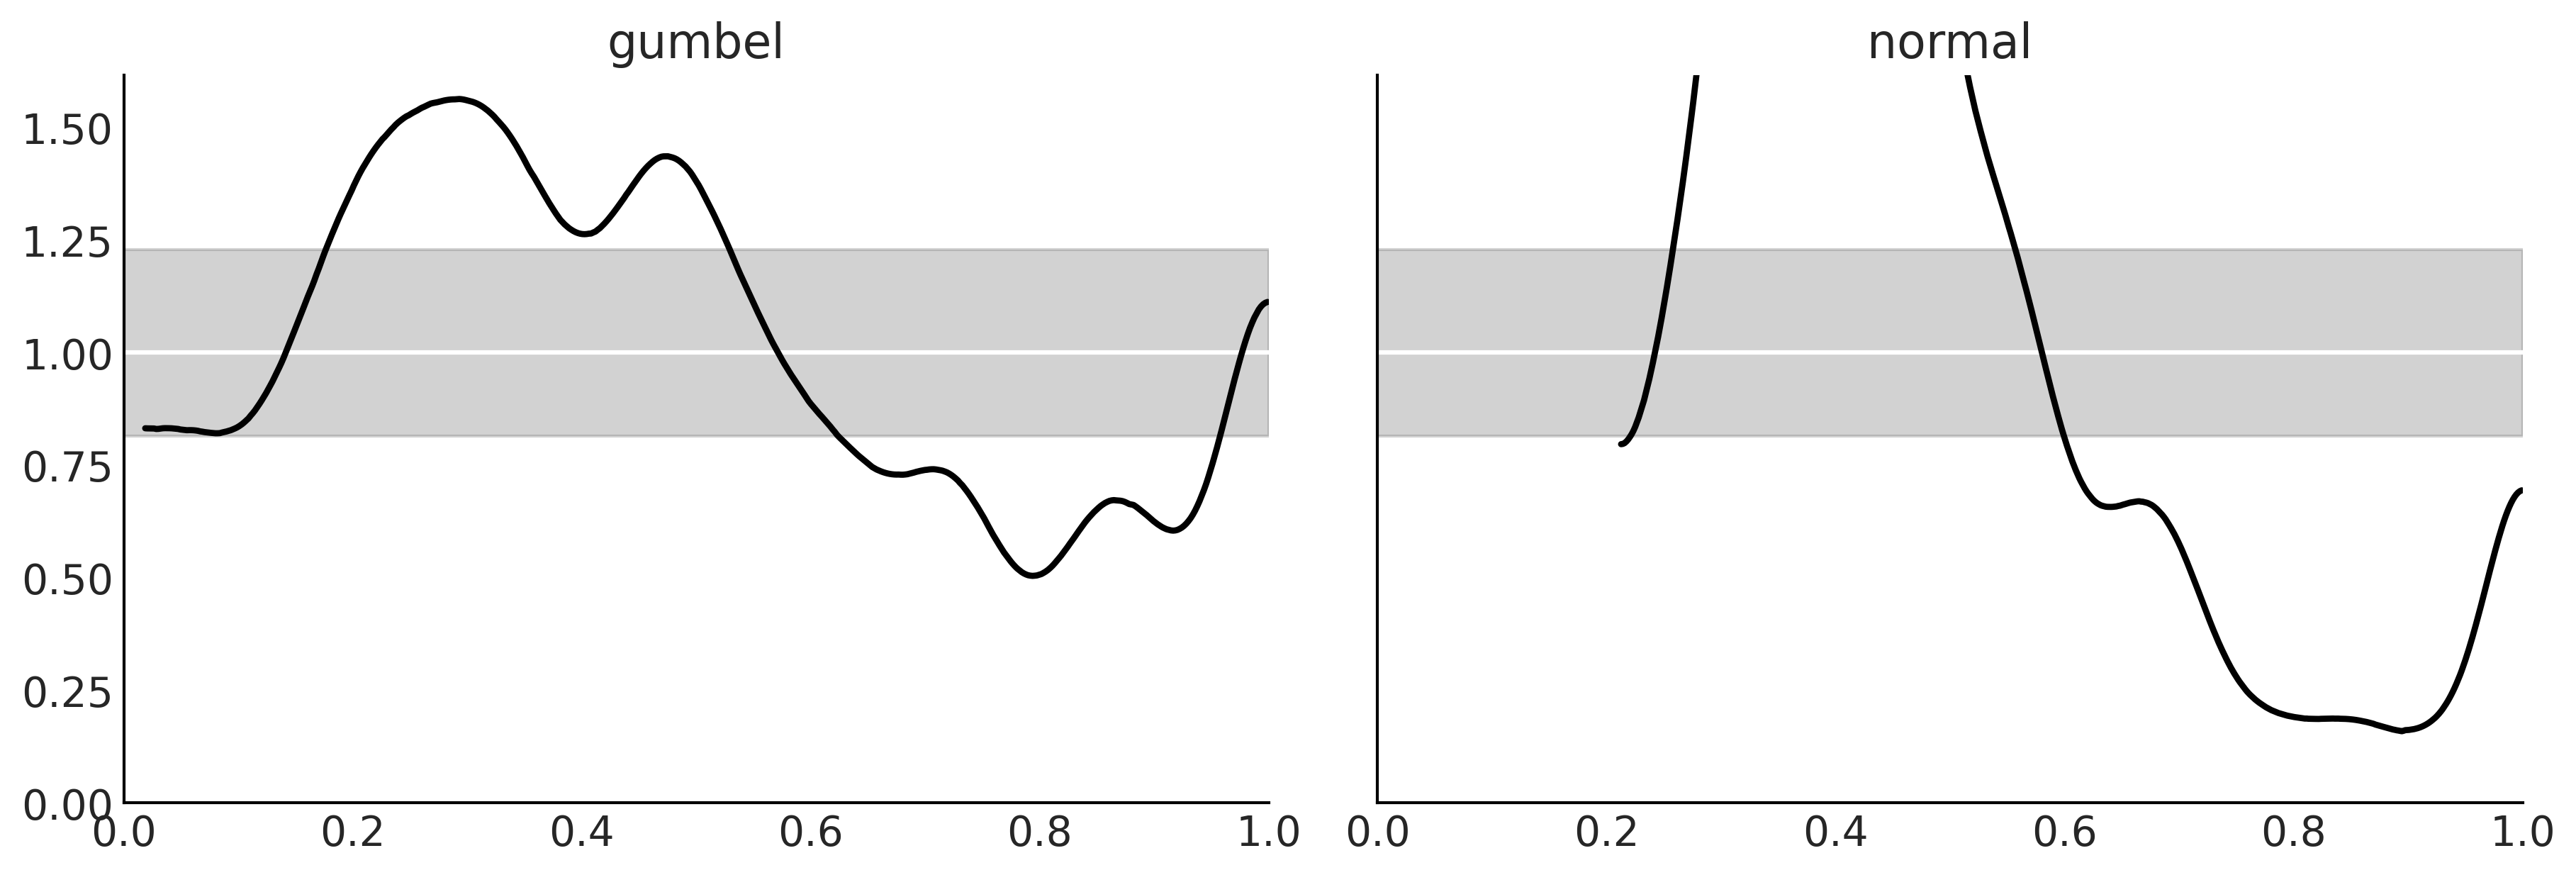

In [140]:
_, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for label, model, ax in zip(("gumbel", "normal"),(gumbel_data, normal_data), axes):
    az.plot_loo_pit(model, y="delays", legend=False, use_hdi=True, ax=ax)
    ax.set_title(label)
    
plt.savefig('img/loo_pit_delays.png')

In [141]:


cmp_dict = {"gumbel": gumbel_data,
            "normal": normal_data}
            
cmp = az.compare(cmp_dict)

/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<AxesSubplot:xlabel='Log'>

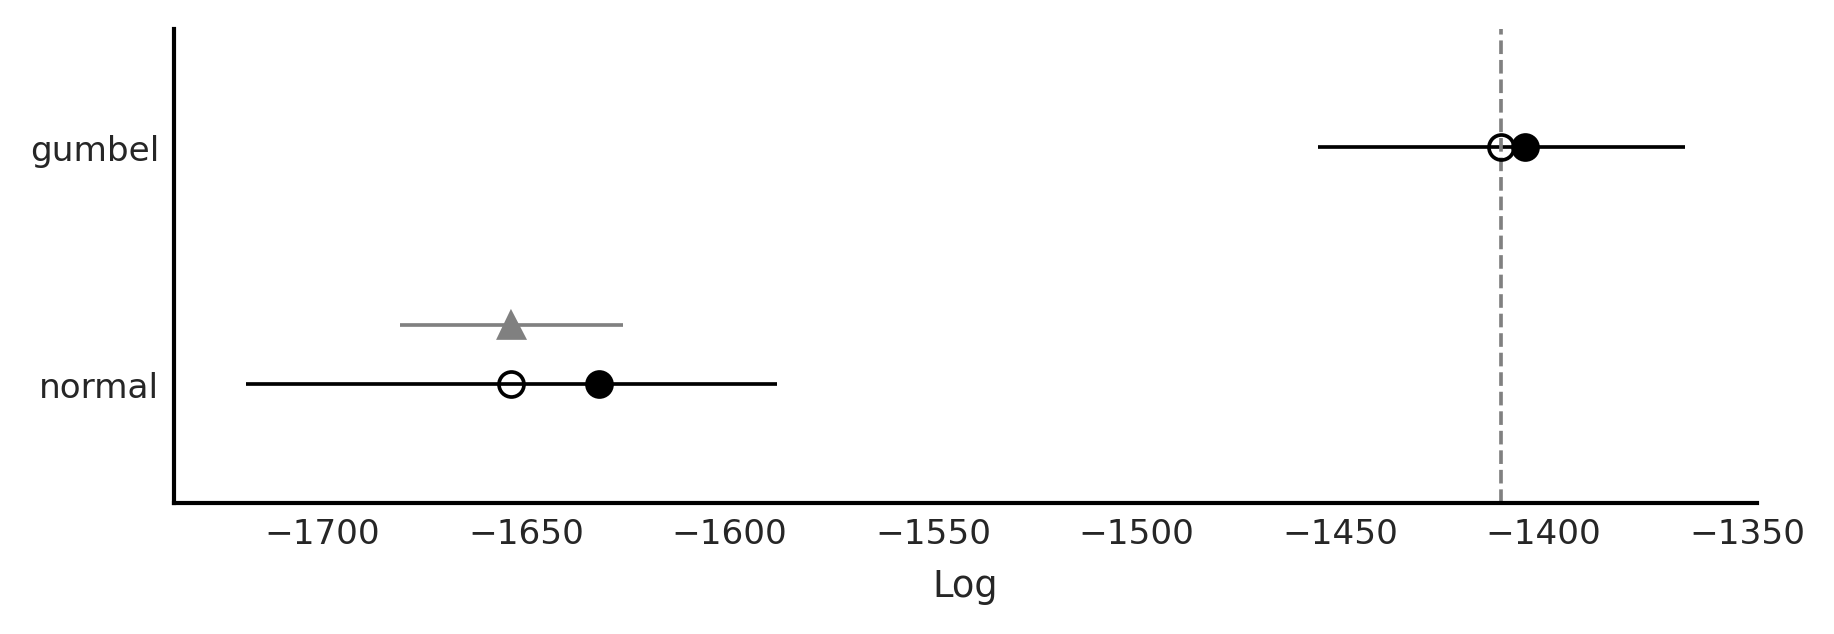

In [142]:
az.plot_compare(cmp)

## ELPD Plot

In [143]:
gumbel_loo = az.loo(gumbel_data, pointwise=True)
normal_loo = az.loo(normal_data, pointwise=True)

/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


/home/canyon/miniconda3/envs/cargo/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


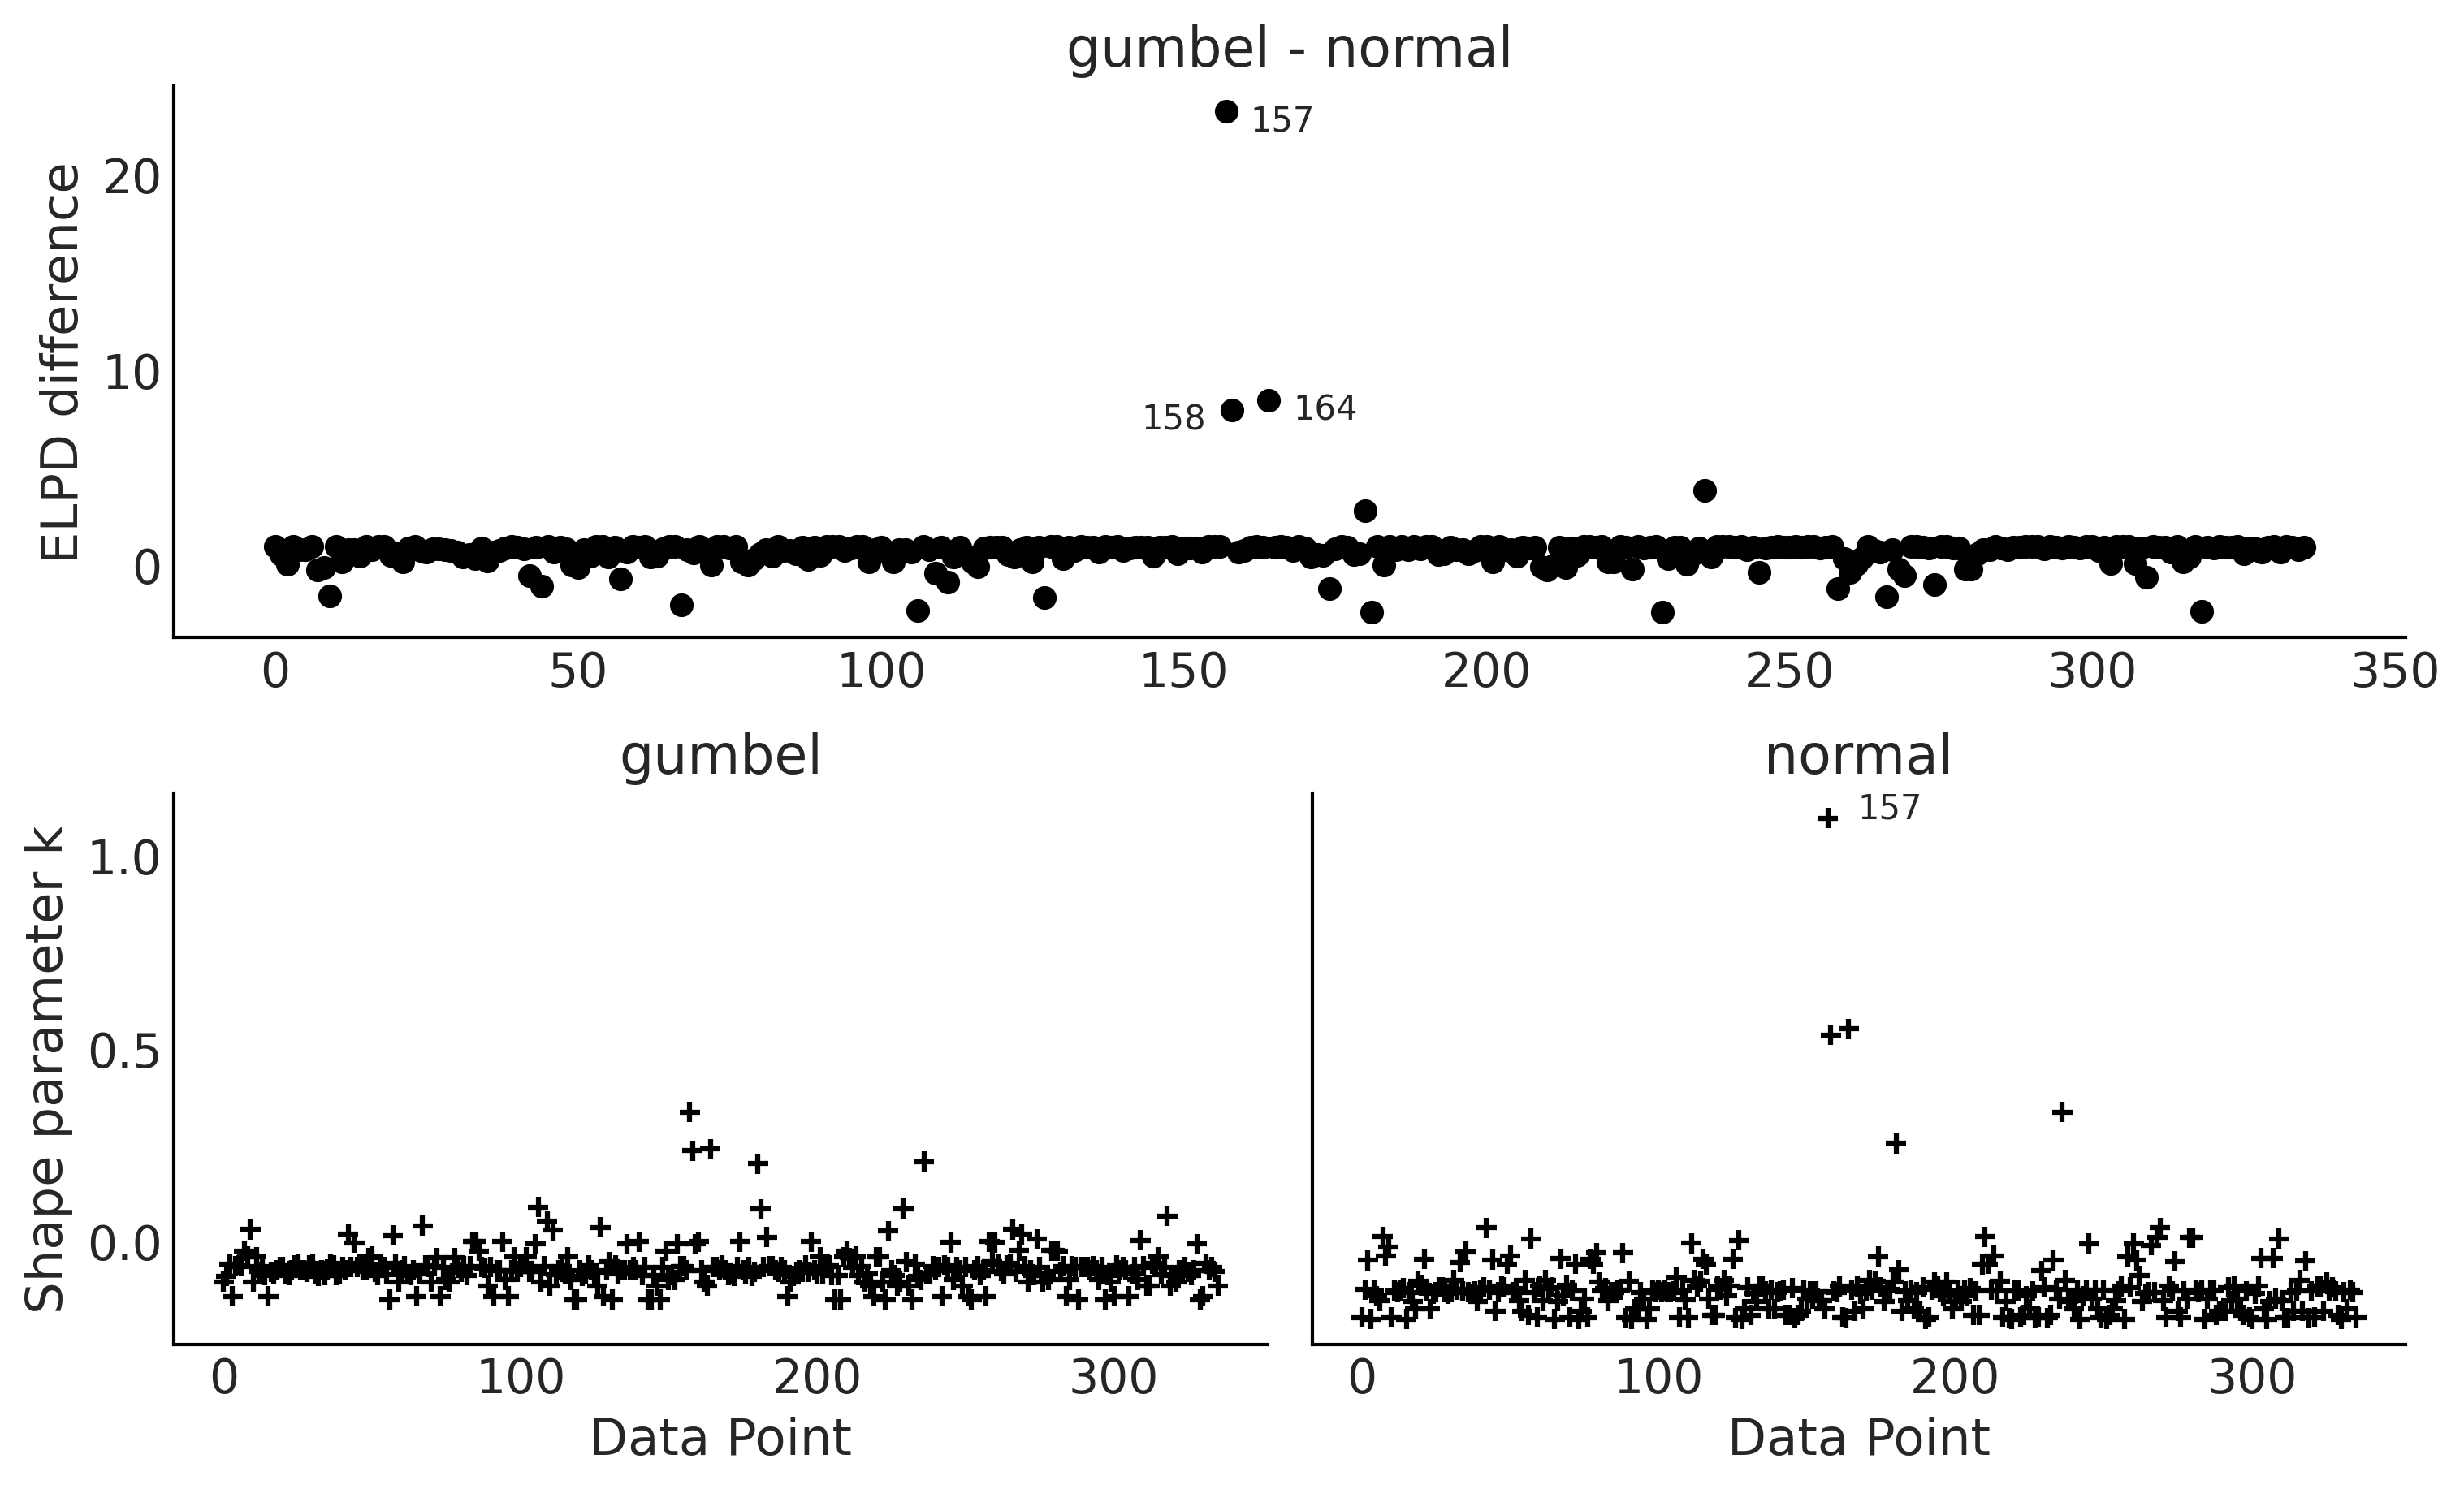

In [144]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])


diff = gumbel_loo.loo_i - normal_loo.loo_i
idx = np.abs(diff) > 4
x_values = np.where(idx)[0]
y_values = diff[idx].values
az.plot_elpd(cmp_dict, ax=ax)

for x, y, in zip(x_values, y_values):
    if x != 158:
        x_pos = x+4
    else:
        x_pos = x-15
    ax.text(x_pos, y-1, x)
    
for label, elpd_data, ax in zip(("gumbel", "normal"),
                                (gumbel_loo, normal_loo), (ax1, ax2)):
    az.plot_khat(elpd_data, ax=ax)
    ax.set_title(label)
    idx = elpd_data.pareto_k > 0.7
    x_values = np.where(idx)[0]
    y_values = elpd_data.pareto_k[idx].values
    for x, y, in zip(x_values, y_values):
        if x != 158:
            x_pos = x+10
        else:
            x_pos = x-30
        ax.text(x_pos, y, x)
    

#     ttl = ax.title
#    ttl.set_position([.5, 10])

ax1.set_ylim(ax2.get_ylim())
ax2.set_ylabel("")
ax2.set_yticks([])
plt.savefig('img/elpd_plot_delays.png');

## Reward functions

In [145]:
posterior_pred = gumbel_data.posterior_predictive["delays"].values.reshape(-1, 336).copy()

In [146]:
@np.vectorize
def current_revenue(delay):
    """Calculates revenue """
    if delay >= 0:
        return 300*delay
    return np.nan

In [147]:
def revenue_calculator(posterior_pred, revenue_func):    
    revenue_per_flight = revenue_func(posterior_pred)
    average_revenue = np.nanmean(revenue_per_flight)
    return revenue_per_flight, average_revenue

In [157]:
revenue_per_flight, average_revenue = revenue_calculator(posterior_pred, current_revenue)
average_revenue

3930.8899204759587

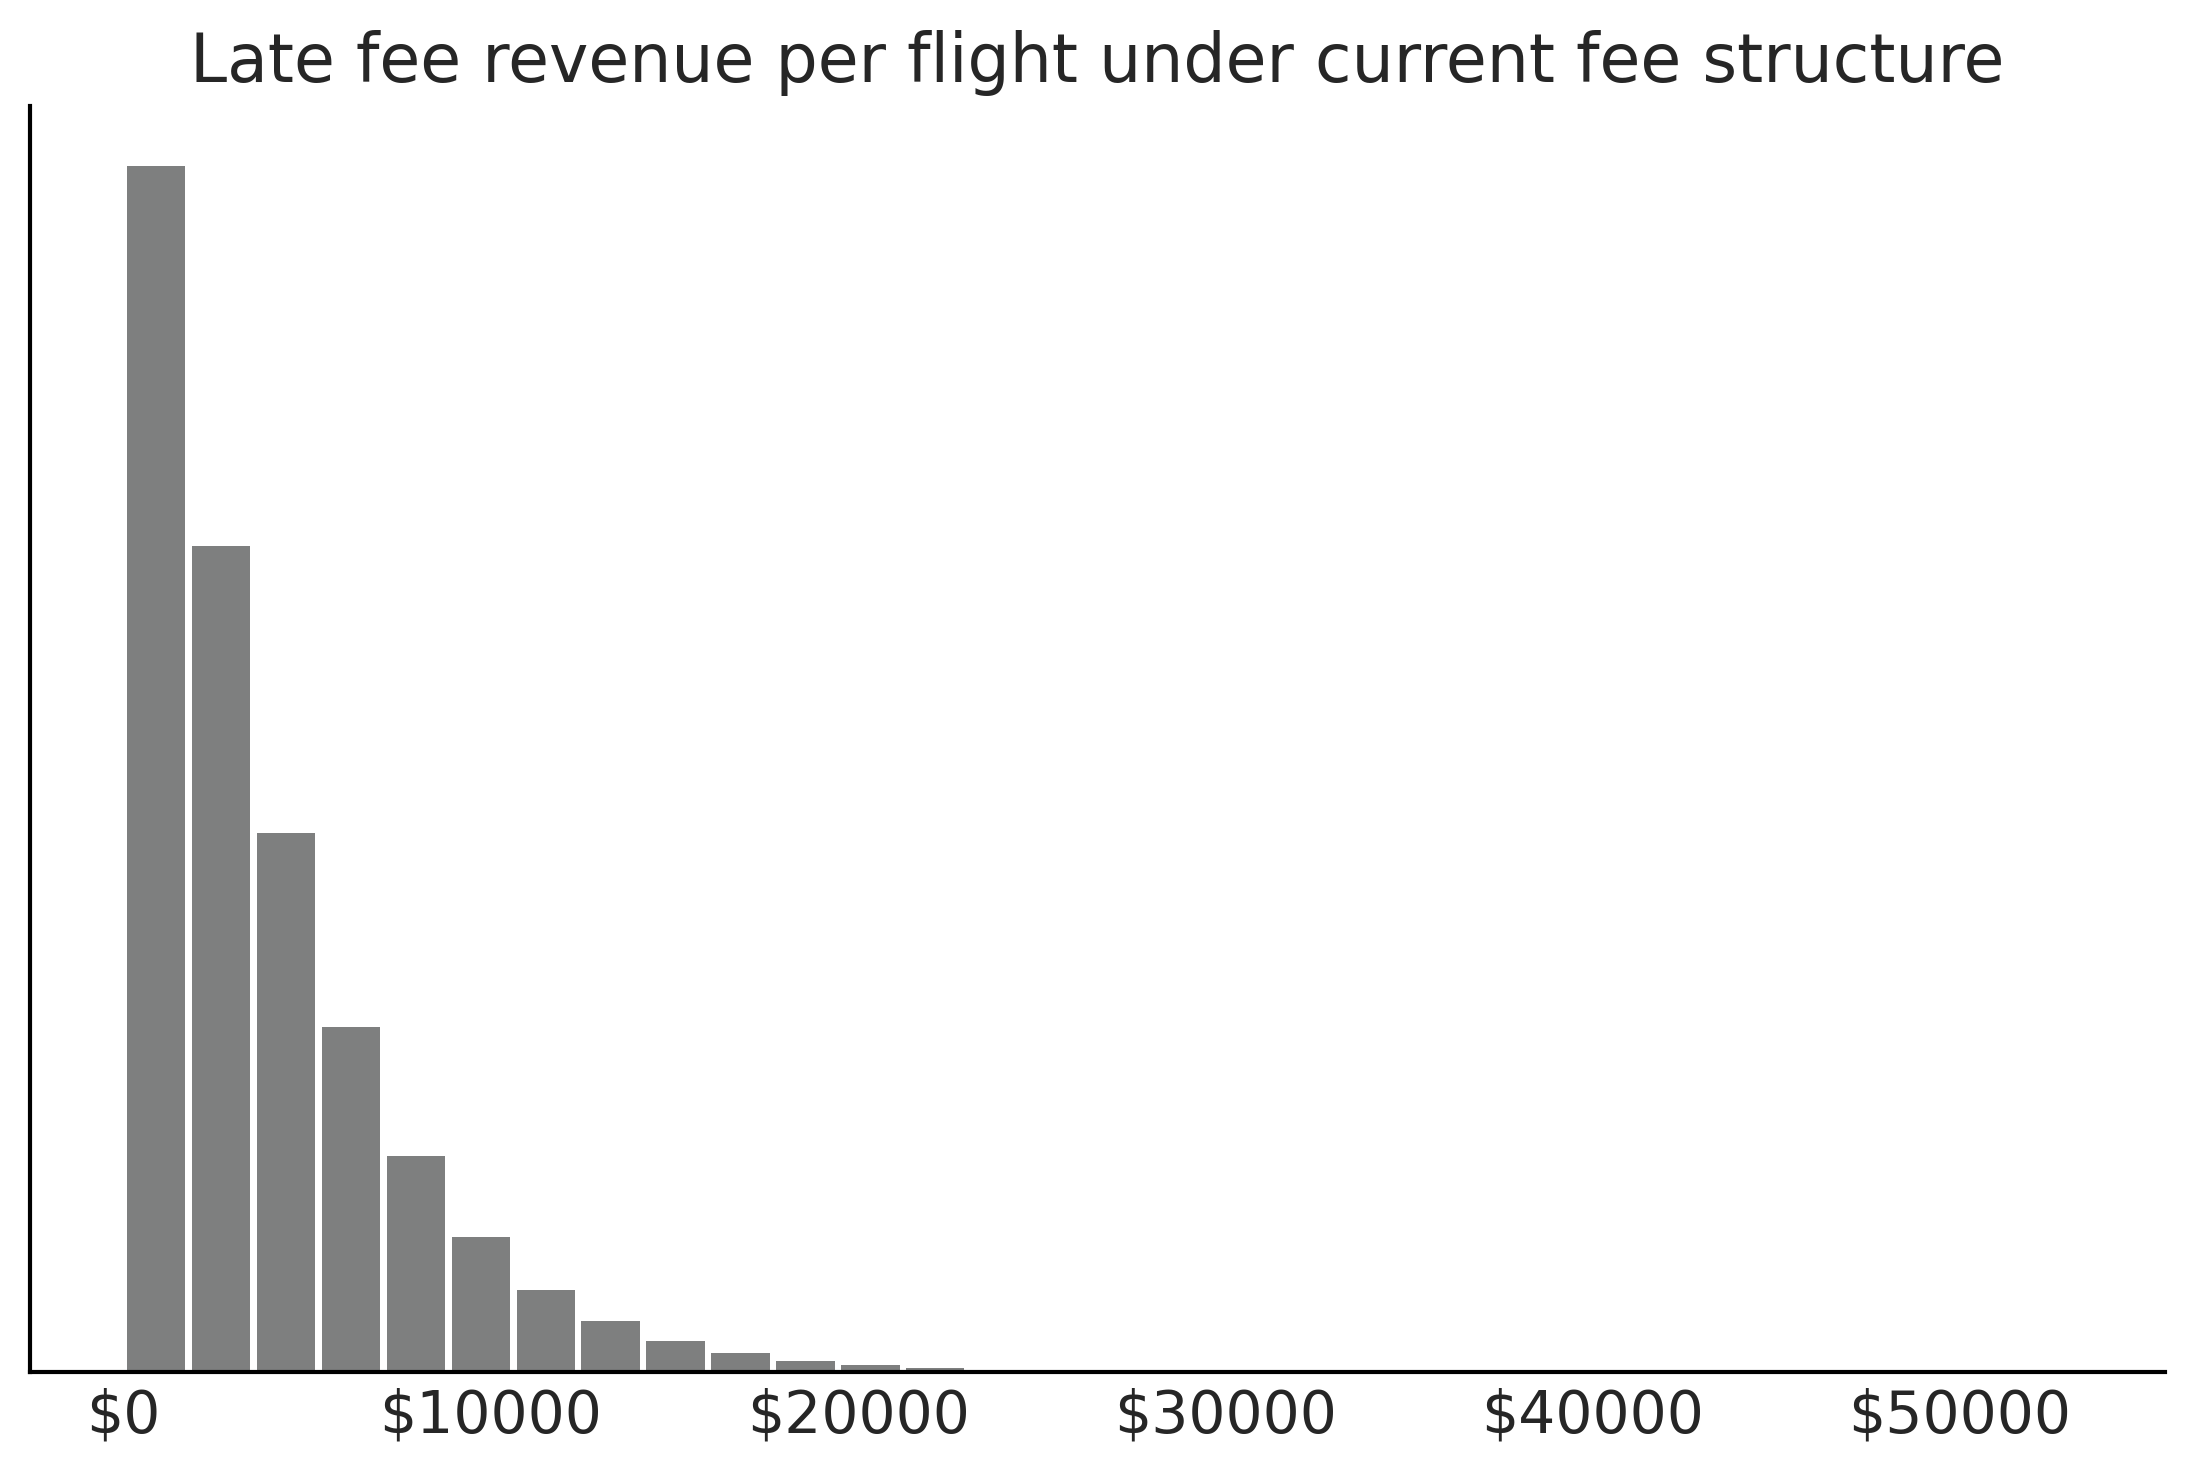

In [200]:
fig, ax = plt.subplots()
ax.hist(revenue_per_flight.flatten(), bins=30, rwidth=.9, color="C2" )
ax.set_yticks([])
ax.set_title("Late fee revenue per flight under current fee structure")
ax.xaxis.set_major_formatter('${x:1.0f}')
plt.savefig("img/Late_fee_current_structure_hist.png")

In [150]:
@np.vectorize
def proposed_revenue(delay):
    """Calculates revenue """
    if delay >= 100:
        return 30000
    elif delay >= 10:
        return 5000
    elif delay >= 0:
        return 1000
    else:
        return np.nan

In [162]:
revenue_per_flight_proposed, average_revenue_proposed = revenue_calculator(posterior_pred, proposed_revenue)
average_revenue_proposed

2921.977902254481

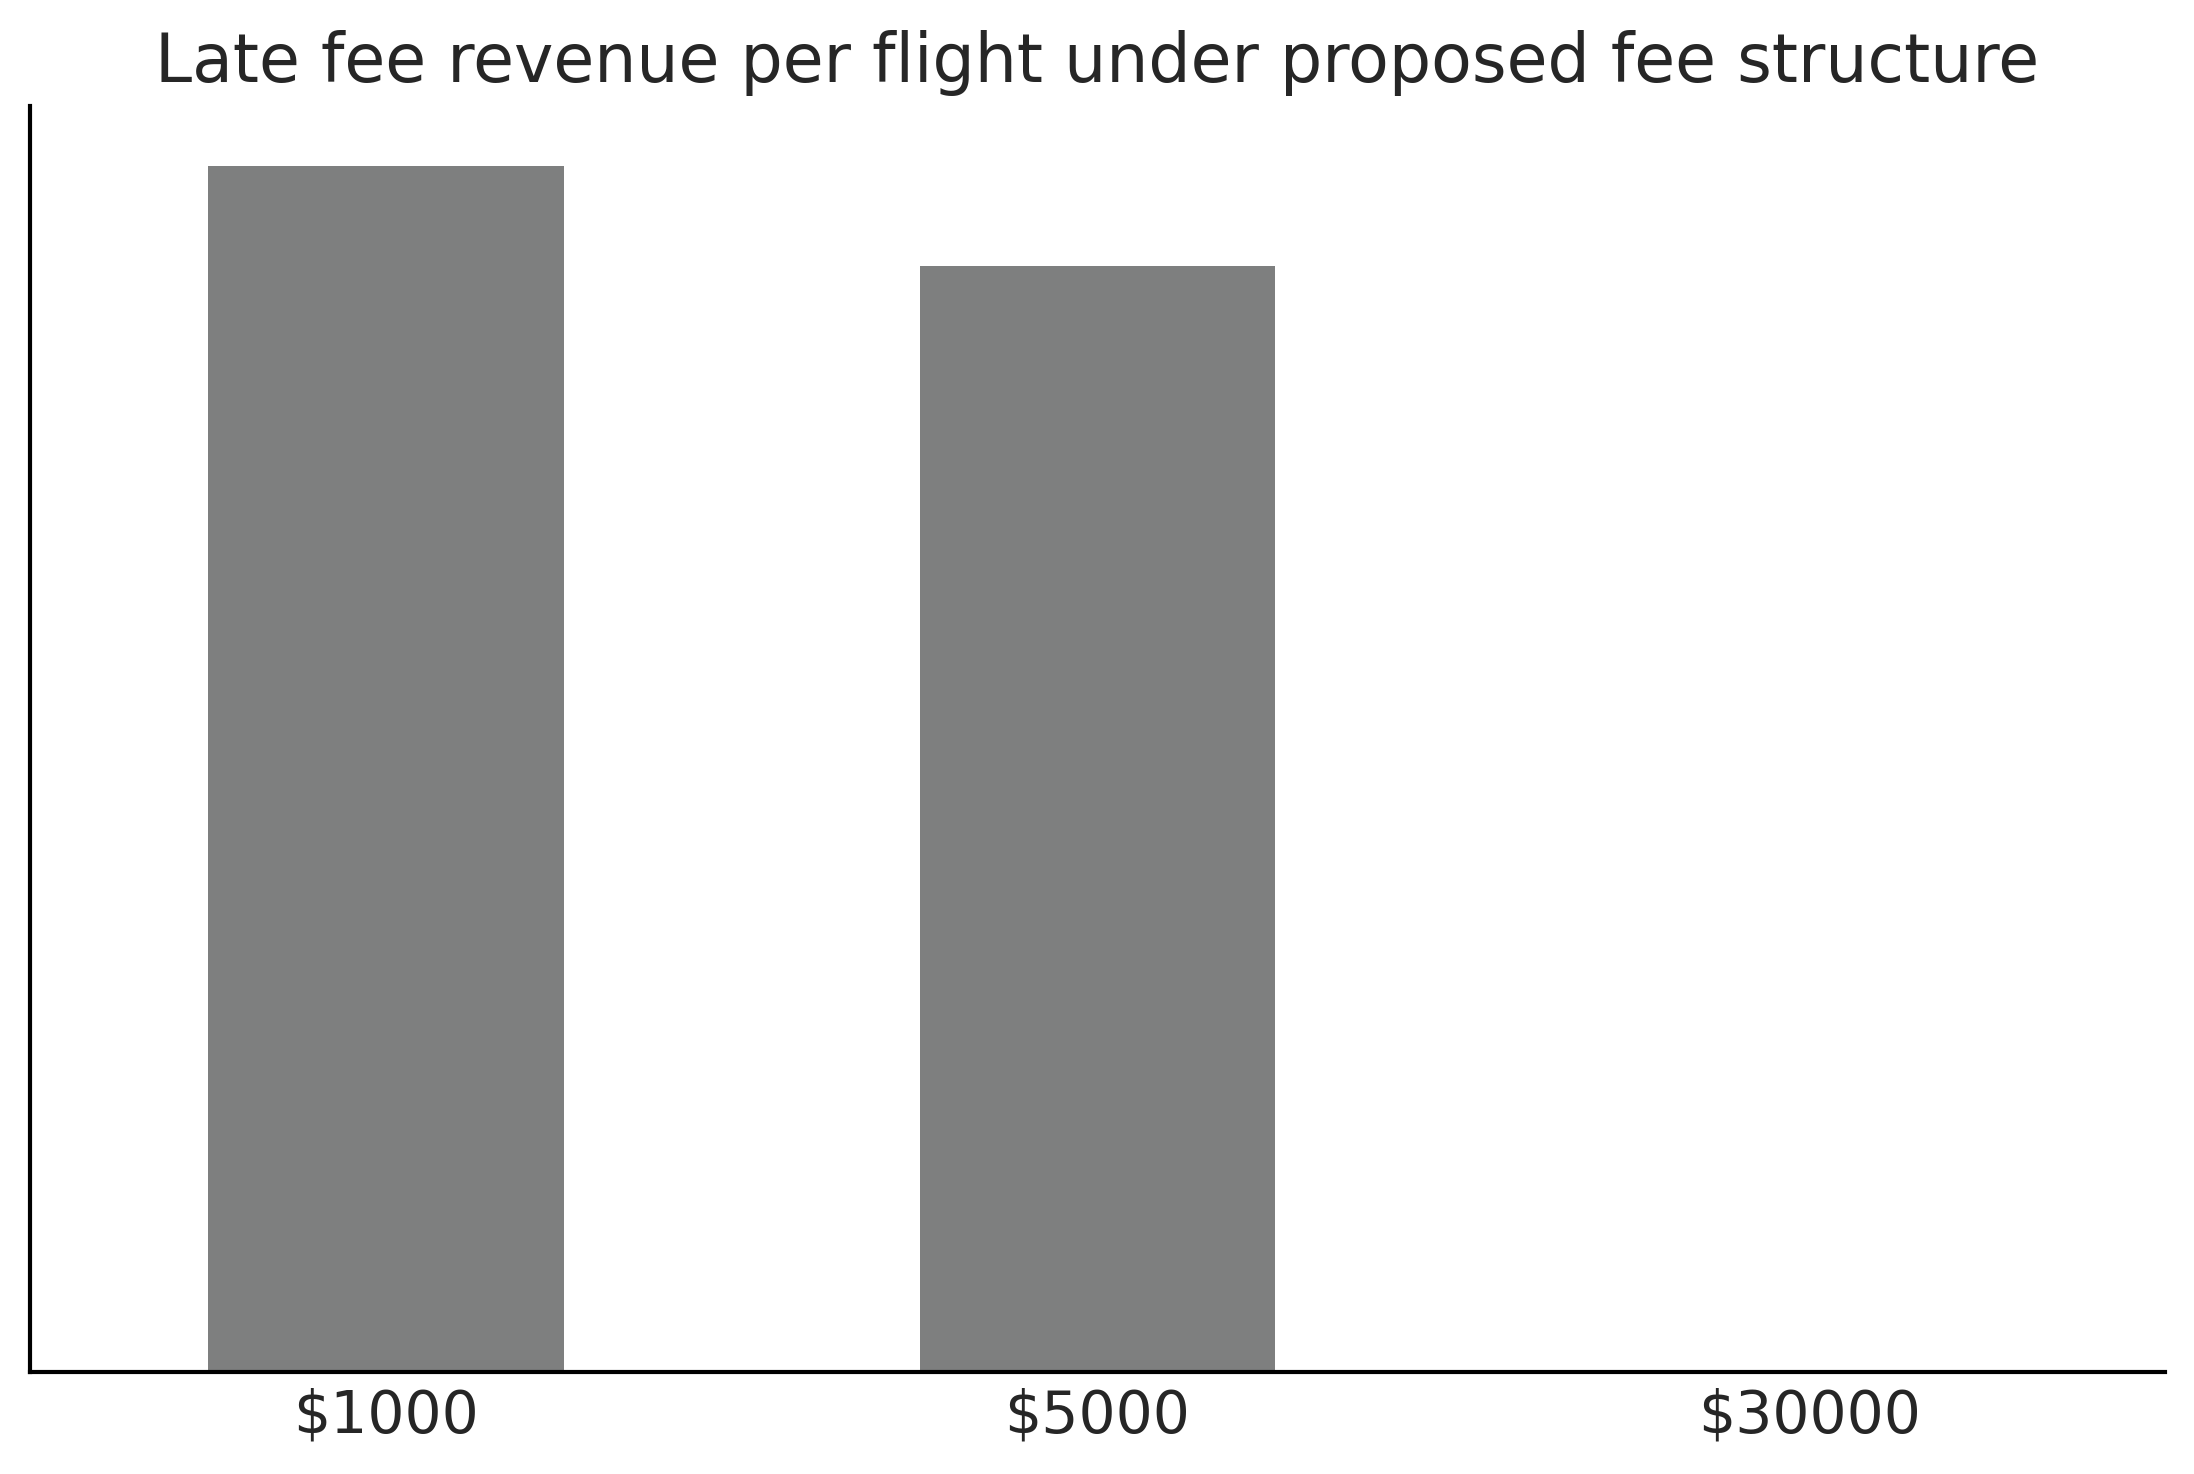

In [199]:
fig, ax = plt.subplots()

counts = pd.Series(revenue_per_flight_proposed.flatten()).value_counts()
counts.index = counts.index.astype(int)

counts.plot(kind="bar", ax=ax, color="C2")
ax.set_title("Late fee revenue per flight under proposed fee structure")
ax.set_yticks([]);
ax.tick_params(axis='x', labelrotation = 0)
ax.set_xticklabels([f"${i}" for i in counts.index])

plt.savefig("img/Late_fee_proposed_structure_hist.png");

In [153]:
counts

1000     1110310
5000     1018490
30000        648
dtype: int64

In [154]:
counts/counts.sum()*100

1000     52.140743
5000     47.828827
30000     0.030430
dtype: float64